# Title: 'Tree-based ML for insurance pricing'
## Based on : Book Interpretation Tools for ML methods and 'Tree-based ML for insurance pricing'  on Github by 'Roel Henckaerts, Marie-Pier Côté, Katrien Antonio and Roel Verbelen'

# Structure of the notebook
* [I - DATA](#four)

* [II - Models](#four)
    + [1. Claim frequency](#four-one)
        - [1.1 Training with Decision tree and XGboosting](#four-one-training)
        - [1.2 Tuning with Grid search](#four-one-tuning)
        
    + [2. Claim severity](#four-two)
        - [2.1 Training with Decision tree and XGboosting](#four-two-training)
        - [2.2 Tuning with random search](#four-two-tuning)


* [III - Interpretation tools](#two)
    + [1. Feature importance](#two-one)
    + [2. Partial dependence](#two-two)
    + [3. Statistical importance](#two-three)
    + [4. Economic impact](#two-four)

In [141]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from scipy.special import gamma
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.tree import plot_tree
# instead of contructing them from scratch we import them sklearn.metrics
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance

## DATA


In [142]:
mtpl_orig = pd.read_csv('Assignment.csv')
df2 = pd.read_excel('inspost.xls')
# Merge df1 and df2 based on the common column 'CODPOSS'
mtpl = mtpl_orig.merge(df2, left_on='CODPOSS', right_on='CODPOSS')

mtpl

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,INS,COMMUNE,LAT,LONG
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,21004,BRUSSEL,50.833333,4.350000
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,21004,BRUSSEL,50.833333,4.350000
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,21004,BRUSSEL,50.833333,4.350000
3,62,1000,1.000000,0.000000,0,0.000000,0.000000,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,21004,BRUSSEL,50.833333,4.350000
4,41,1000,1.000000,0.000000,1,1.000000,62.419590,6-10,Female,Petrol,Monthly,Private,No,No,MTPL,66-110,21004,BRUSSEL,50.833333,4.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,1.000000,0.000000,0,0.000000,0.000000,6-10,Male,Petrol,Once,Private,No,No,MTPL,<66,24041,HOEGAARDEN,50.766667,4.883333
163653,42,4770,1.000000,0.000000,1,1.000000,516.337423,>10,Male,Gasoil,Once,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667
163654,48,4770,1.000000,0.000000,0,0.000000,0.000000,>10,Male,Petrol,Monthly,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667
163655,27,4770,1.000000,0.000000,0,0.000000,0.000000,6-10,Male,Petrol,Twice,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667


In [143]:
# describe 

mtpl.describe()
print (mtpl.describe(include = 'object'))

        agecar    sexp   fuelc   split     usec  fleetc  sportc  coverp  \
count   163657  163657  163657  163657   163657  163657  163657  163657   
unique       4       2       2       4        2       2       2       3   
top       6-10    Male  Petrol    Once  Private      No      No    MTPL   
freq     67151  120434  113210   81479   155652  158428  162145   95409   

        powerc    COMMUNE  
count   163657     163657  
unique       3        583  
top        <66  CHARLEROI  
freq    119809       5038  


In [144]:

# Rename columns to lowercase
mtpl.columns = [col.lower() for col in mtpl.columns]

# Redefine split 
replacement_dict = {'Once': 1, 'Twice': 2, 'Thrice': 3, 'Monthly': 12}

# Replace values in the 'col1' column using the dictionary
mtpl['split'] = mtpl['split'].replace(replacement_dict)

# Calculate mean and frequency
m = mtpl['nbrtotc'].mean()
freq = mtpl['nbrtotc'].sum() / mtpl['duree'].sum()

# Print dimensions
print(mtpl.shape)

(163657, 20)


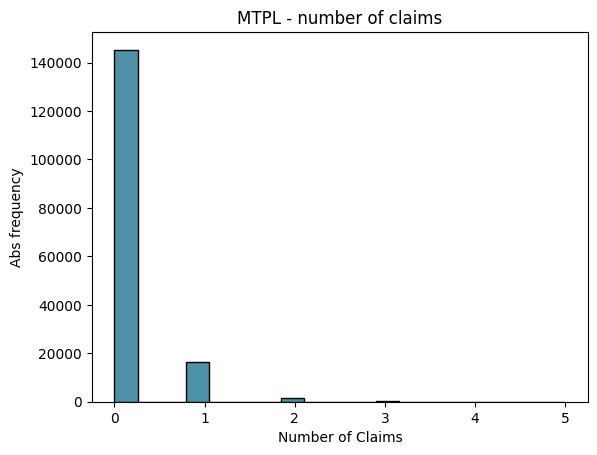

In [5]:
# Visualization
KULbg = "#116E8A"
g = sns.histplot(mtpl['nbrtotc'], color=KULbg)
g.set(xlabel='Number of Claims', ylabel='Abs frequency', title='MTPL - number of claims')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:416: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


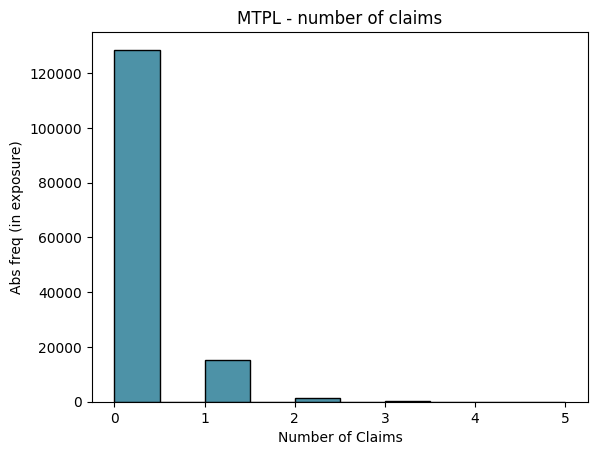

In [6]:
g = sns.histplot(mtpl, x='nbrtotc', weights='duree', color=KULbg)
g.set(xlabel='Number of Claims', ylabel='Abs freq (in exposure)', title='MTPL - number of claims')
plt.show()

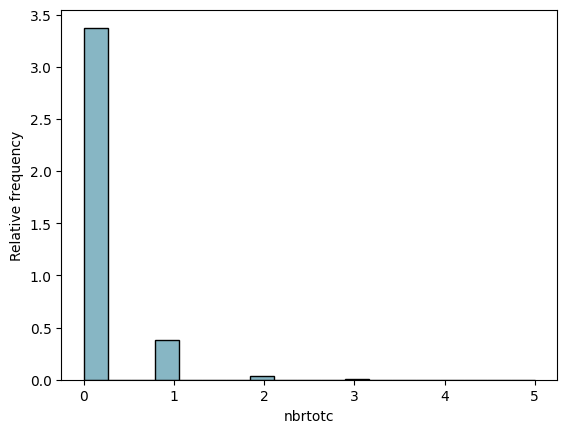

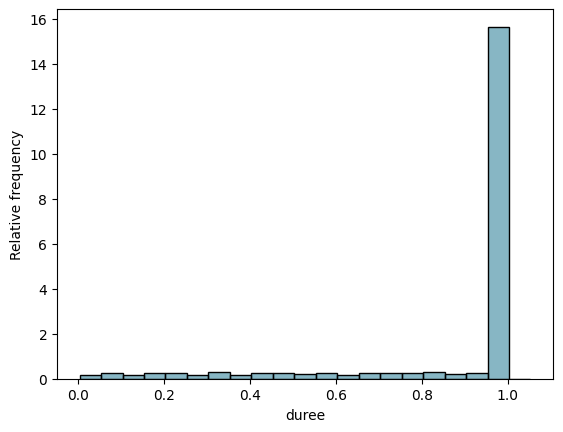

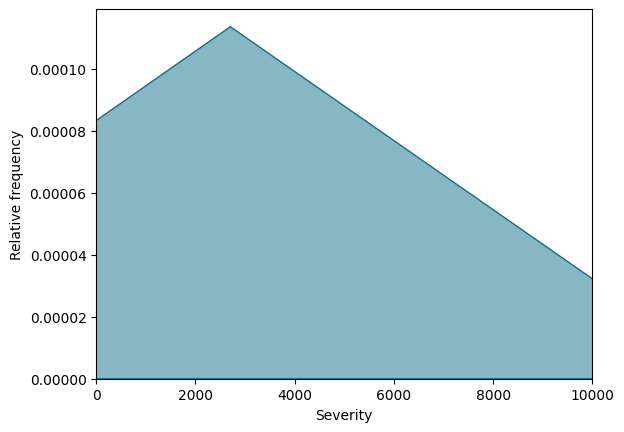

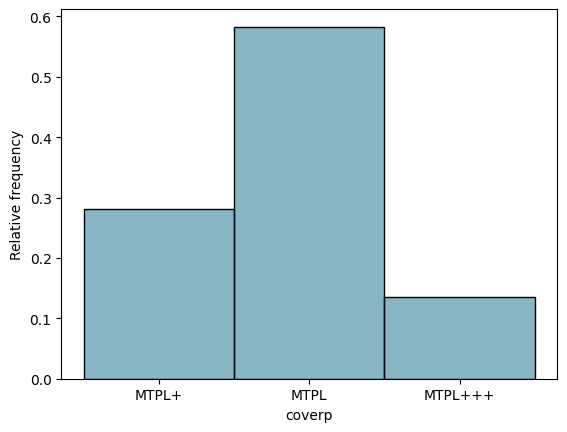

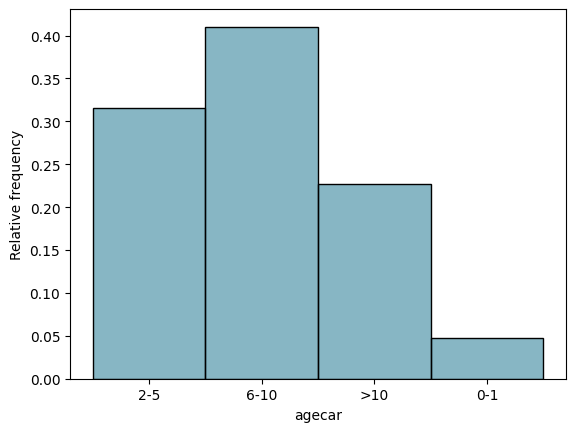

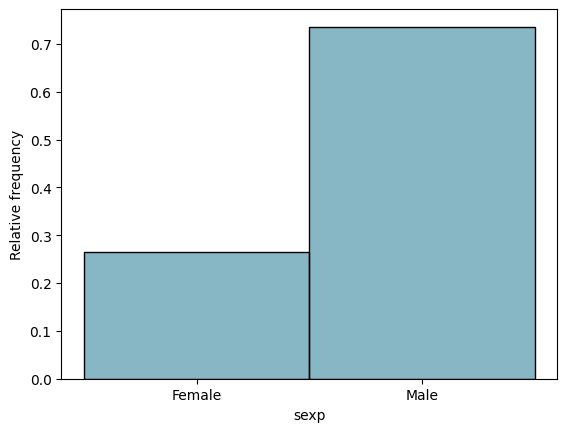

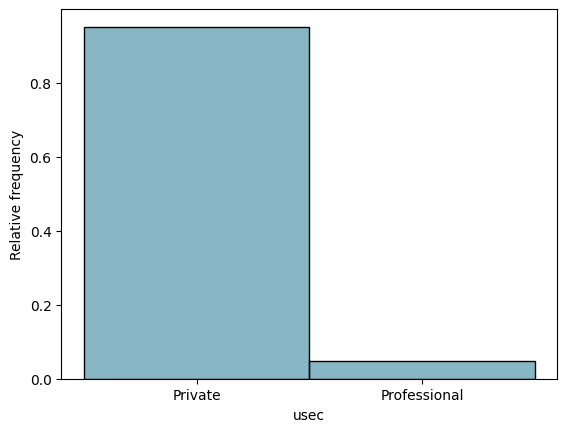

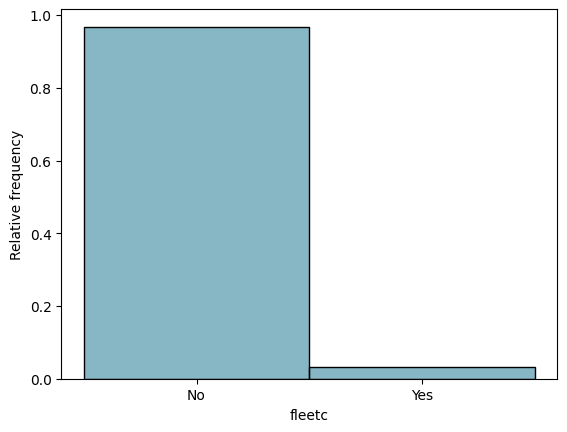

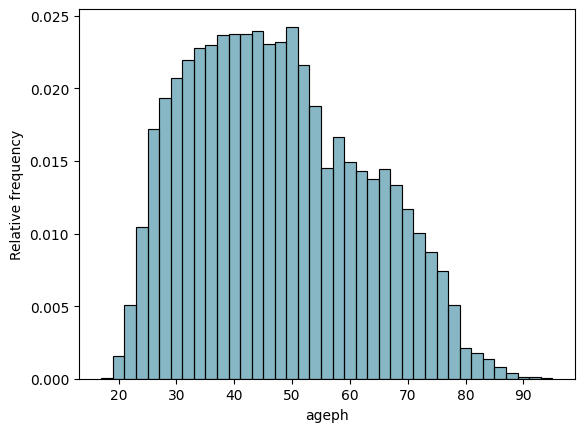

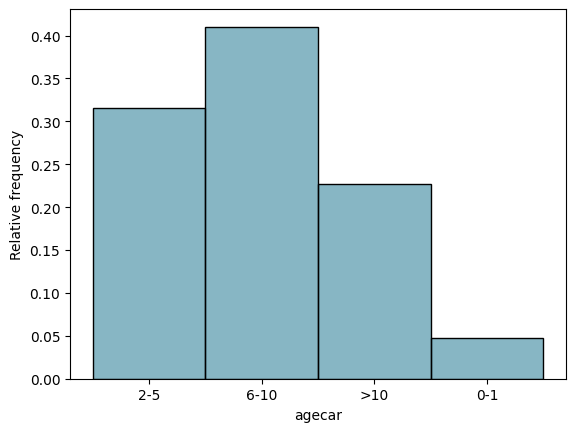

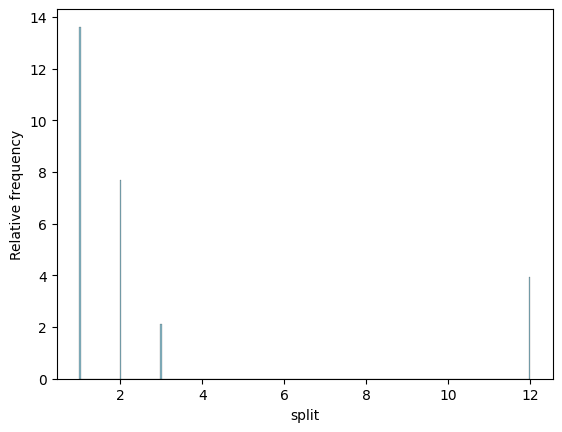

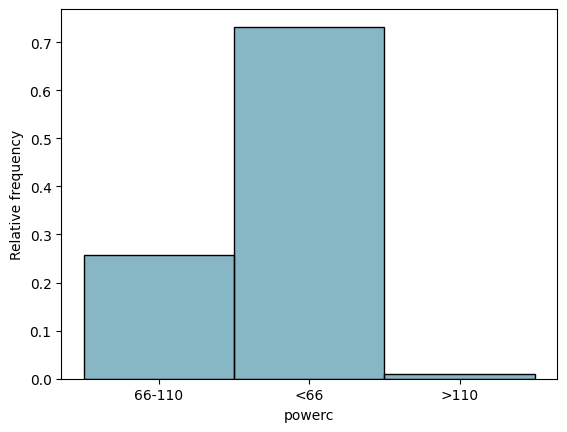

In [7]:
# Wrapper functions
def ggplot_bar(DT, variable, xlab):
    g = sns.histplot(data=DT, x=variable, stat='density', color=KULbg, alpha=0.5)
    g.set(xlabel=xlab, ylabel='Relative frequency')
    plt.show()

def ggplot_hist(DT, variable, xlab, binwidth):
    g = sns.histplot(data=DT, x=variable, binwidth=binwidth, stat='density', color=KULbg, alpha=0.5)
    g.set(xlabel=xlab, ylabel='Relative frequency')
    plt.show()
# Targets: frequency, exposure, and total severity
ggplot_bar(mtpl, 'nbrtotc', 'nbrtotc')
ggplot_hist(mtpl, 'duree', 'duree', 0.05)

mtpl_sev = mtpl[(mtpl['chargtot'] > 0)]# & (mtpl['avg'] <= 81000)]  # Filter data
g = sns.kdeplot(data=mtpl_sev['chargtot'], color=KULbg, fill=True, alpha=0.5)
g.set(xlabel='Severity', ylabel='Relative frequency')
plt.xlim(0, 1e4)
plt.show()

# Bar plots of factor variables
for column in ['coverp', 'agecar', 'sexp', 'usec', 'fleetc']:
    ggplot_bar(mtpl, column, column)

# Histograms of continuous variables
ggplot_hist(mtpl, 'ageph', 'ageph', 2)
ggplot_hist(mtpl, 'agecar', 'agecar', 1)
ggplot_bar(mtpl, 'split', 'split')
ggplot_hist(mtpl, 'powerc', 'powerc', 10)

#### Our graphs shows that we are modeling integer-valued frequency
data or right-skewed severity data, this motivates the use of loss functions which are not based on the squared error loss.

             ageph   codposs     duree    lnexpo   nbrtotc  nbrtotan  \
ageph     1.000000 -0.029827  0.099901  0.078857 -0.069035 -0.038769   
codposs  -0.029827  1.000000  0.070874  0.061599 -0.017948 -0.010157   
duree     0.099901  0.070874  1.000000  0.913371  0.052203 -0.068061   
lnexpo    0.078857  0.061599  0.913371  1.000000  0.056768 -0.081085   
nbrtotc  -0.069035 -0.017948  0.052203  0.056768  1.000000  0.471175   
nbrtotan -0.038769 -0.010157 -0.068061 -0.081085  0.471175  1.000000   
chargtot -0.010823  0.001296  0.000843  0.002014  0.100368  0.058756   
split    -0.114590 -0.207059 -0.256008 -0.220810  0.016326  0.022017   
ins       0.026376  0.377525  0.018485  0.017844 -0.019480 -0.012680   
lat      -0.052471 -0.150414  0.004351  0.000507  0.010329  0.006249   
long      0.049076 -0.533458 -0.039023 -0.033159 -0.004210 -0.005207   

          chargtot     split       ins       lat      long  
ageph    -0.010823 -0.114590  0.026376 -0.052471  0.049076  
codposs   0.0

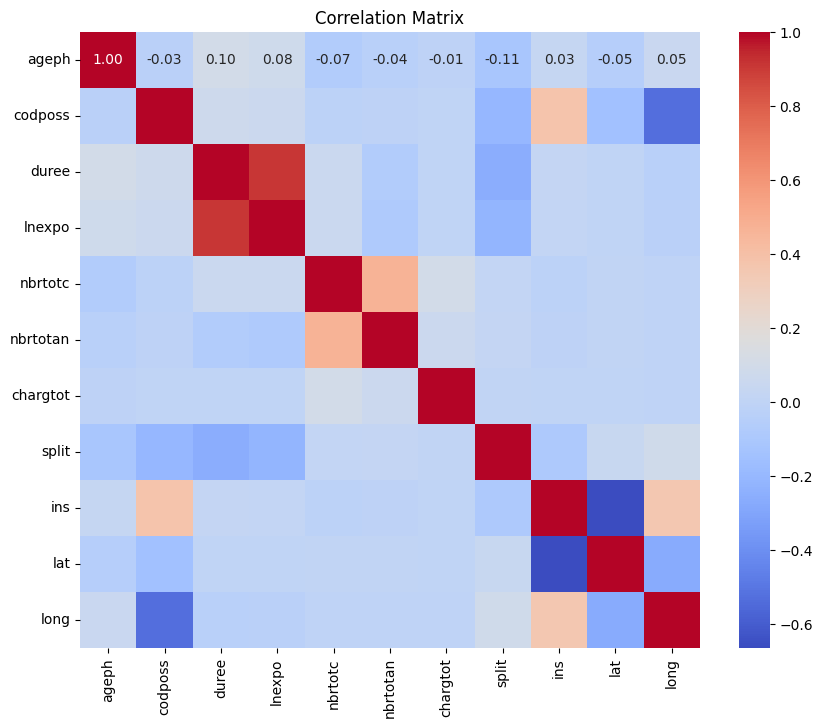

In [8]:
# Assuming df is your DataFrame
correlation_matrix = mtpl.corr()

# Print correlation matrix
print(correlation_matrix)

# Visualize correlation matrix (optional)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Here we can see a high correlation between duree and ln expo so we drop the ln expo collumn in our mtpl.


In [9]:

#Here we can see a high correlation between duree and ln expo so we drop the ln expo collumn in our mtpl.
mtpl = mtpl.drop("lnexpo", axis=1)


In [10]:
mtpl1 = mtpl
mtpl1.columns

Index(['ageph', 'codposs', 'duree', 'nbrtotc', 'nbrtotan', 'chargtot',
       'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc',
       'coverp', 'powerc', 'ins', 'commune', 'lat', 'long'],
      dtype='object')

In [11]:
mtpl

,ageph,codposs,duree,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long
0,64,1000,1.000000,0,0.000000,0.000000,2-5,Female,Petrol,1,Private,No,No,MTPL+,66-110,21004,BRUSSEL,50.833333,4.350000
1,28,1000,0.046575,1,21.470588,155.974606,6-10,Female,Petrol,2,Private,No,No,MTPL,66-110,21004,BRUSSEL,50.833333,4.350000
2,58,1000,0.402740,0,0.000000,0.000000,>10,Female,Petrol,3,Private,No,No,MTPL,<66,21004,BRUSSEL,50.833333,4.350000
3,62,1000,1.000000,0,0.000000,0.000000,>10,Female,Petrol,1,Private,No,No,MTPL+,<66,21004,BRUSSEL,50.833333,4.350000
4,41,1000,1.000000,1,1.000000,62.419590,6-10,Female,Petrol,12,Private,No,No,MTPL,66-110,21004,BRUSSEL,50.833333,4.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,1.000000,0,0.000000,0.000000,6-10,Male,Petrol,1,Private,No,No,MTPL,<66,24041,HOEGAARDEN,50.766667,4.883333
163653,42,4770,1.000000,1,1.000000,516.337423,>10,Male,Gasoil,1,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667
163654,48,4770,1.000000,0,0.000000,0.000000,>10,Male,Petrol,12,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667
163655,27,4770,1.000000,0,0.000000,0.000000,6-10,Male,Petrol,2,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667


###### For ML applications, we need to transform all our columns to a numerical input. We will transform our categorical features to integers:

In [12]:
# map string values to integers for certain columns

cats1 = [col for col in mtpl1.columns if mtpl1[col].dtype == 'object']

# Identify columns with strings

label_encoder = LabelEncoder()
for col in cats1:
    mtpl1[col] = label_encoder.fit_transform(mtpl1[col])



#unique_values = mtpl['powerc'].unique()
#print(type(unique_values))
#print(unique_values)
#mltp1['powerc'].unique()
#print (cats1,mtpl.describe(include = 'object'))

mtpl1.dtypes

ageph         int64
codposs       int64
duree       float64
nbrtotc       int64
nbrtotan    float64
chargtot    float64
agecar        int64
sexp          int64
fuelc         int64
split         int64
usec          int64
fleetc        int64
sportc        int64
coverp        int64
powerc        int64
ins           int64
commune       int64
lat         float64
long        float64
dtype: object

 
#### For claim frequency modeling involves count data, typically assumed to be Poisson distributed 
Therefore, an appropriate loss function is the Poisson deviance, defined as follows:
 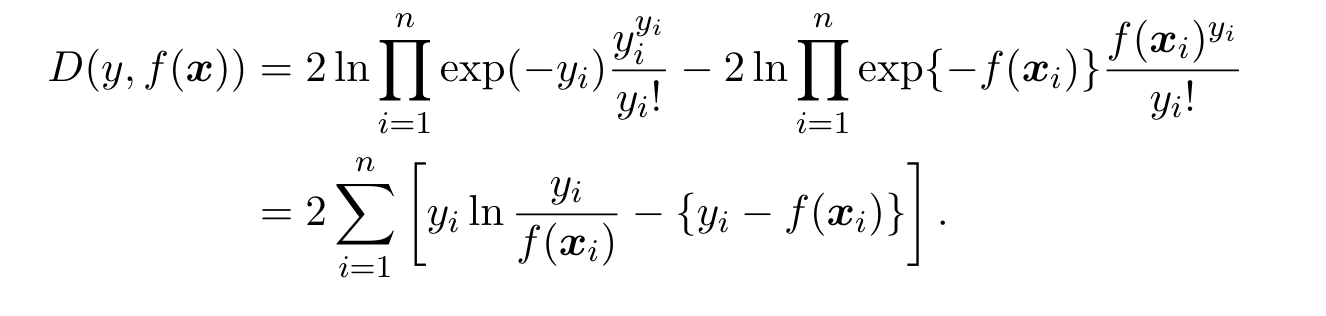
 
#### For severity modeling involves count data, typically assumed to be Gamma distributed 
Right-skewed and long-tailed severity data is typically assumed to be gamma.
The gamma deviance is defined as follows:
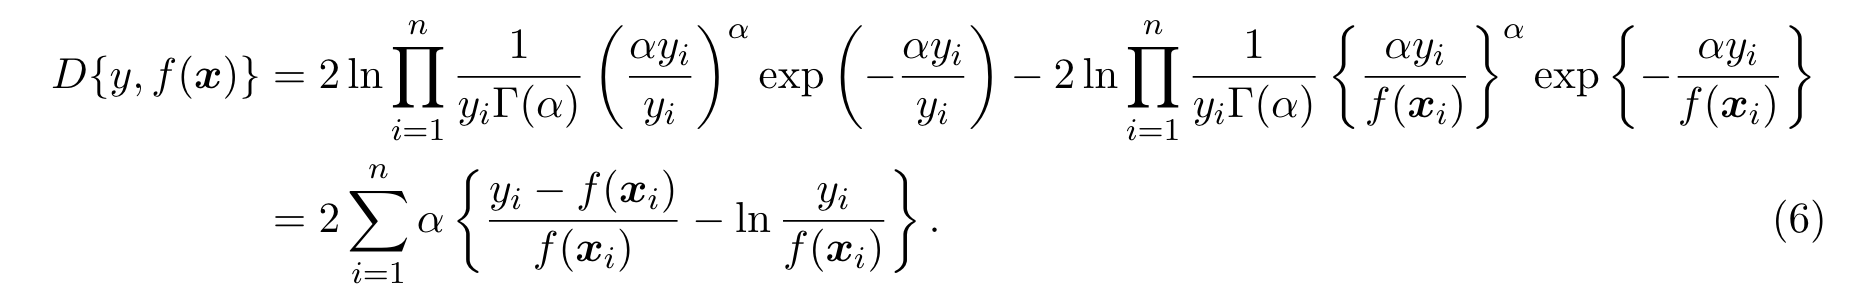

So we can define our loss functions based on the appropriate deviance.

### Deviance loss function for poisson and gamma
When using an exposure-to-risk measure ei
, f(xi) is replaced by ei
·f(xi) such that the exposure
is taken into account in the expected number of claims. This site https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/metrics/_regression.py teaches us how Deviance loss function for poisson and gamma are constructed and how to consider the exposure as weights.


In [13]:
def poisson_deviance1(y_true, y_pred):
    # Poisson distribution
    e = np.exp(-80) ## to avoid y_true==0 for claims
    #pp= (y_true+result) / y_pred
    #for element in pp:
        #print(np.log(element))
        # Calculate the condition
    
    deviance = 2 * np.sum(y_true * np.log(y_true+e / y_pred) - (y_true - y_pred))
    return deviance/len(y_true) 

In [14]:
def gamma_deviance(y_true, y_pred, alpha):
    exposure = X_train['duree']
    e = np.exp(-80)
    n_samples = len(y_true)
    deviance = 2 * np.sum(
        (alpha * ((y_true+e) - y_pred) / y_pred) - np.log((y_true+e) / y_pred)
    )
    return deviance / n_samples

## Frequency modeling


## Claim frequency <a name="four-two"></a>
We start our modeling efforts by building a claim frequency `DecisionTreeRegressor` model for the MTPL dataset. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) teaches us that there is a `poisson criterion` which uses reduction in Poisson deviance to find splits

In [15]:
X = mtpl1.drop(columns=['nbrtotc','chargtot','duree', 'nbrtotan']) # 
y = mtpl1['nbrtotc']

# claim frequency (nclaims/expo) as target
y_mtpl_freq = np.array(mtpl1.nbrtotc/mtpl1.duree)
# exposure as weights
w_mtpl_freq = np.array(mtpl.duree)
# cols to retain as features
feat_cols = X.columns
# subset the data
X_mtpl_freq = X[feat_cols]
# print the shape
print(X.shape)
# show the features
#X_mtpl_freq
#y_mtpl_freq

(163657, 15)


### Train and test split

In [16]:
# Split data into training and testing sets


X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X, y_mtpl_freq, test_size=0.2, random_state=42)


## Decision tree FREQ


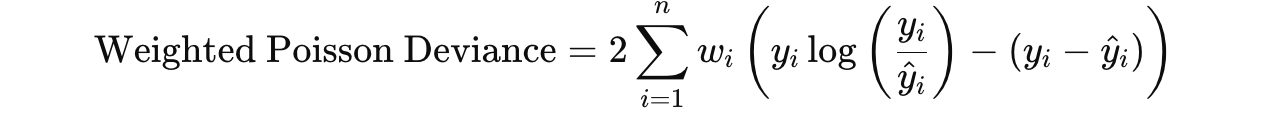

We apply weight so that samples with higher weights have a larger impact on the loss function, while samples with lower weights have a smaller impact. This is because we trust more the samples higher duree.

In [17]:

tree_freq = DecisionTreeRegressor(criterion='poisson', max_depth=10, min_samples_split=10000, min_samples_leaf=5000)
# fit the tree to our target 
tree_freq.fit(X_train_freq, y_train_freq) #, sample_weight=w_mtpl_freq??
# print the tree
tree_freq

DecisionTreeRegressor(criterion='poisson', max_depth=10, min_samples_leaf=5000,
                      min_samples_split=10000)

##### Evaluation on train data

In [18]:
train_predictions = tree_freq.predict(X_train_freq)

# Calculate poisson_deviance on the training set
#exposure = mtpl1['duree']
poisson_dev1 = mean_poisson_deviance(y_train_freq, train_predictions)
print("Training poisson_deviance:", poisson_dev1)


Training poisson_deviance: 0.7885151631196


##### Evaluation on test data

In [19]:
test_Tree_predictions = tree_freq.predict(X_test_freq)

# Calculate poisson_deviance on the training set
#exposure = mtpl1['duree']
poisson_dev1 = mean_poisson_deviance(y_test_freq, test_Tree_predictions)
print("Training poisson_deviance:", poisson_dev1)


Training poisson_deviance: 0.7260394048677671


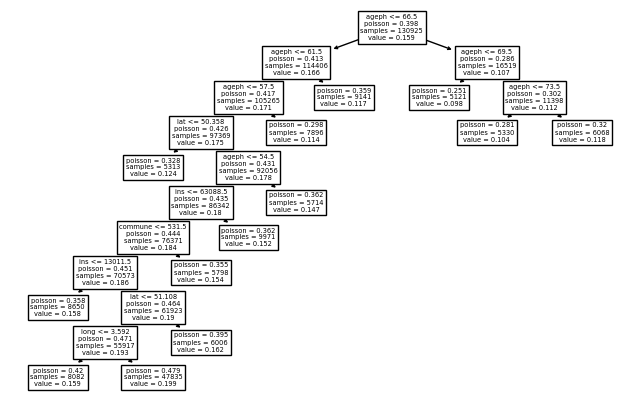

In [20]:
# plot the tree structure
plt.figure(figsize=(8, 5), dpi=100)
plot_tree(tree_freq, feature_names=feat_cols);

## Gradient boosting machine Freq

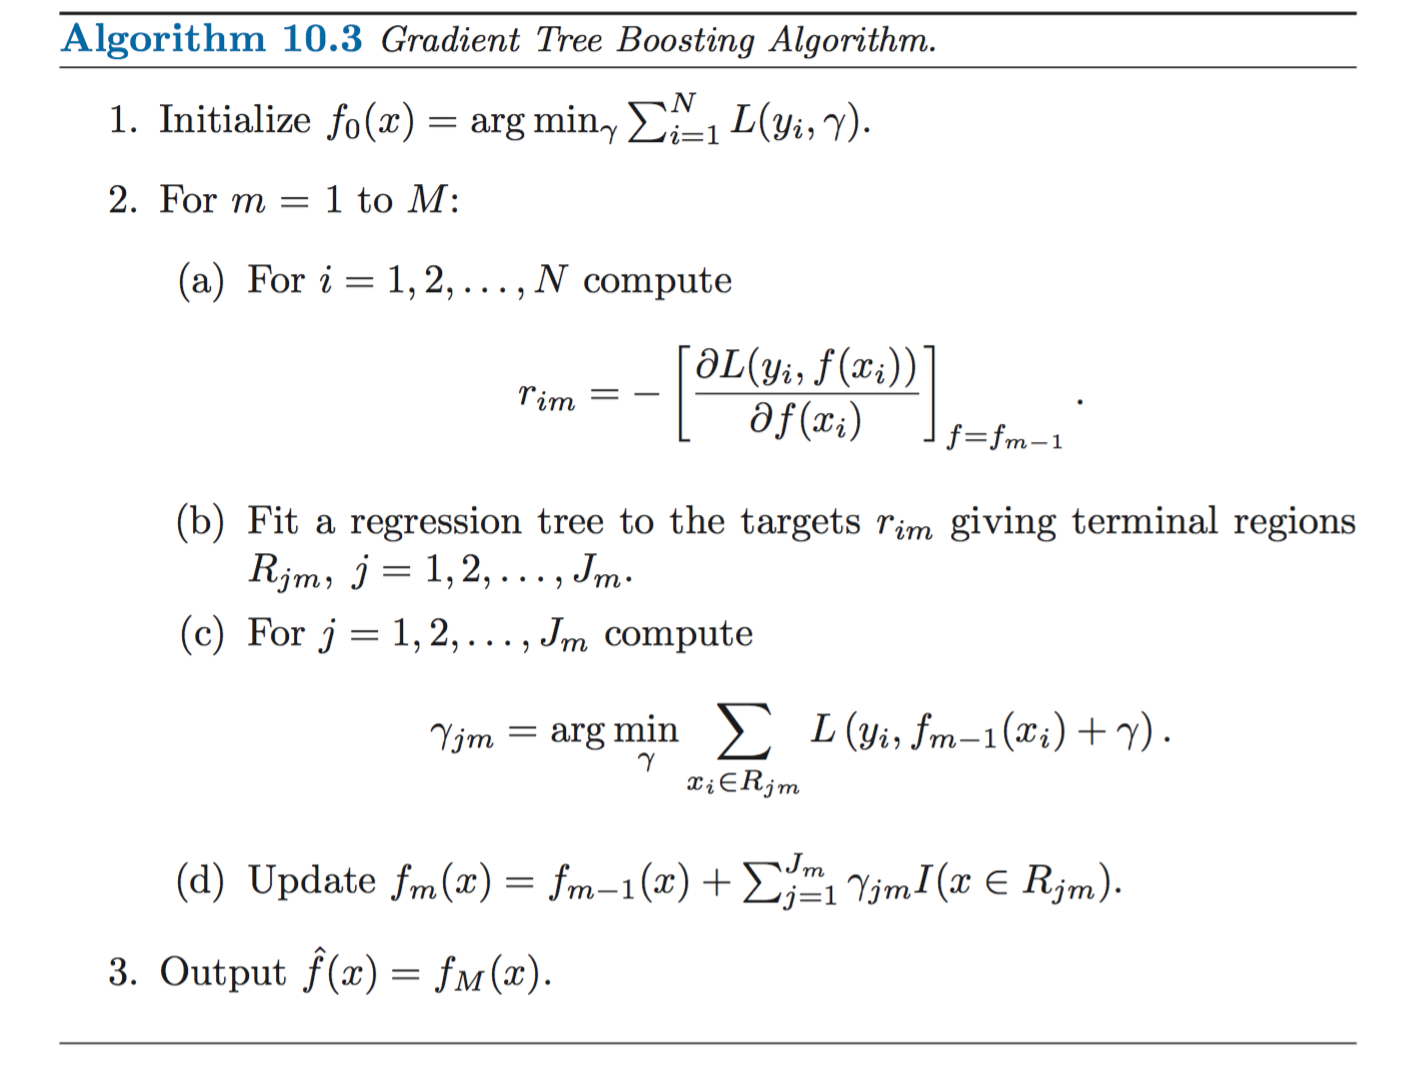


Where N is the number of samples, 𝑀 is the number of iterations and 𝐽𝑚 is the number of terminal regions or size of the tree. Line 3 produces 𝑓̂ (𝑥) which is a 𝐾 sized vector where 𝐾 corresponds to the number of classes.

In libraries like XGBoost the parameter that controls the complexity of the trees is often referred to as:
gamma
We set our gamma to 0.1 aiming to control the complexity of the learned model by penalizing the creation of additional splits in the tree. In this figure it represnts cp (complexity penalty).
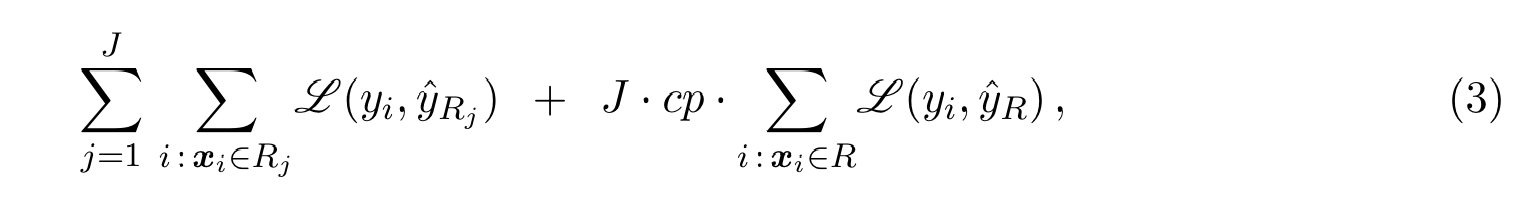

### Custom poisson deviance 
To avoid y_true==0 in the log

In [21]:
from typing import Tuple
def poisson_deviance(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    '''Calculate the Poisson deviance.'''
    y_true = dtrain.get_label()
    y_pred = predt #np.exp(predt)
    e = np.exp(-80)  # to avoid y_true==0 for claims
    deviance = 2 * np.sum(y_true * np.log((y_true + e) / y_pred) - (y_true - y_pred))
    return 'Poisson Deviance', deviance / len(y_true)

In [22]:
params = {
    'objective': 'count:poisson',  # Poisson regression objective
    'max_depth': 6,  # Maximum depth of a tree
    'gamma': 0.1,  # Complexity penalty
    'subsample': 0.75,  # Percentage of data used to train each tree
    'learning_rate': 0.01,  # Shrinkage parameter
    'min_split_loss': 0.01,  # Enforces a stopping criterion for trees
    'eval_metric': poisson_deviance , #costume metric
    'n_estimators':1000 #represents M in our Algo 10.3
}

# Define the XGBoost regressor with the specified parameters
gbm_freq = xgb.XGBRegressor(**params)

# Fit the model on the training data
gbm_freq.fit(X_train_freq, y_train_freq)

# Make predictions on the testing data
y_pred_freq_xg = gbm_freq.predict(X_test_freq)


#on all Data prediction

y_pred_freq_final = gbm_freq.predict(X)

# Evaluate the model
mse = mean_poisson_deviance(y_test_freq, y_pred_freq_xg)
print("mean_poisson_deviance:", mse)

mean_poisson_deviance: 0.7090702768140108


### Crossvalidation comapraison between two models 

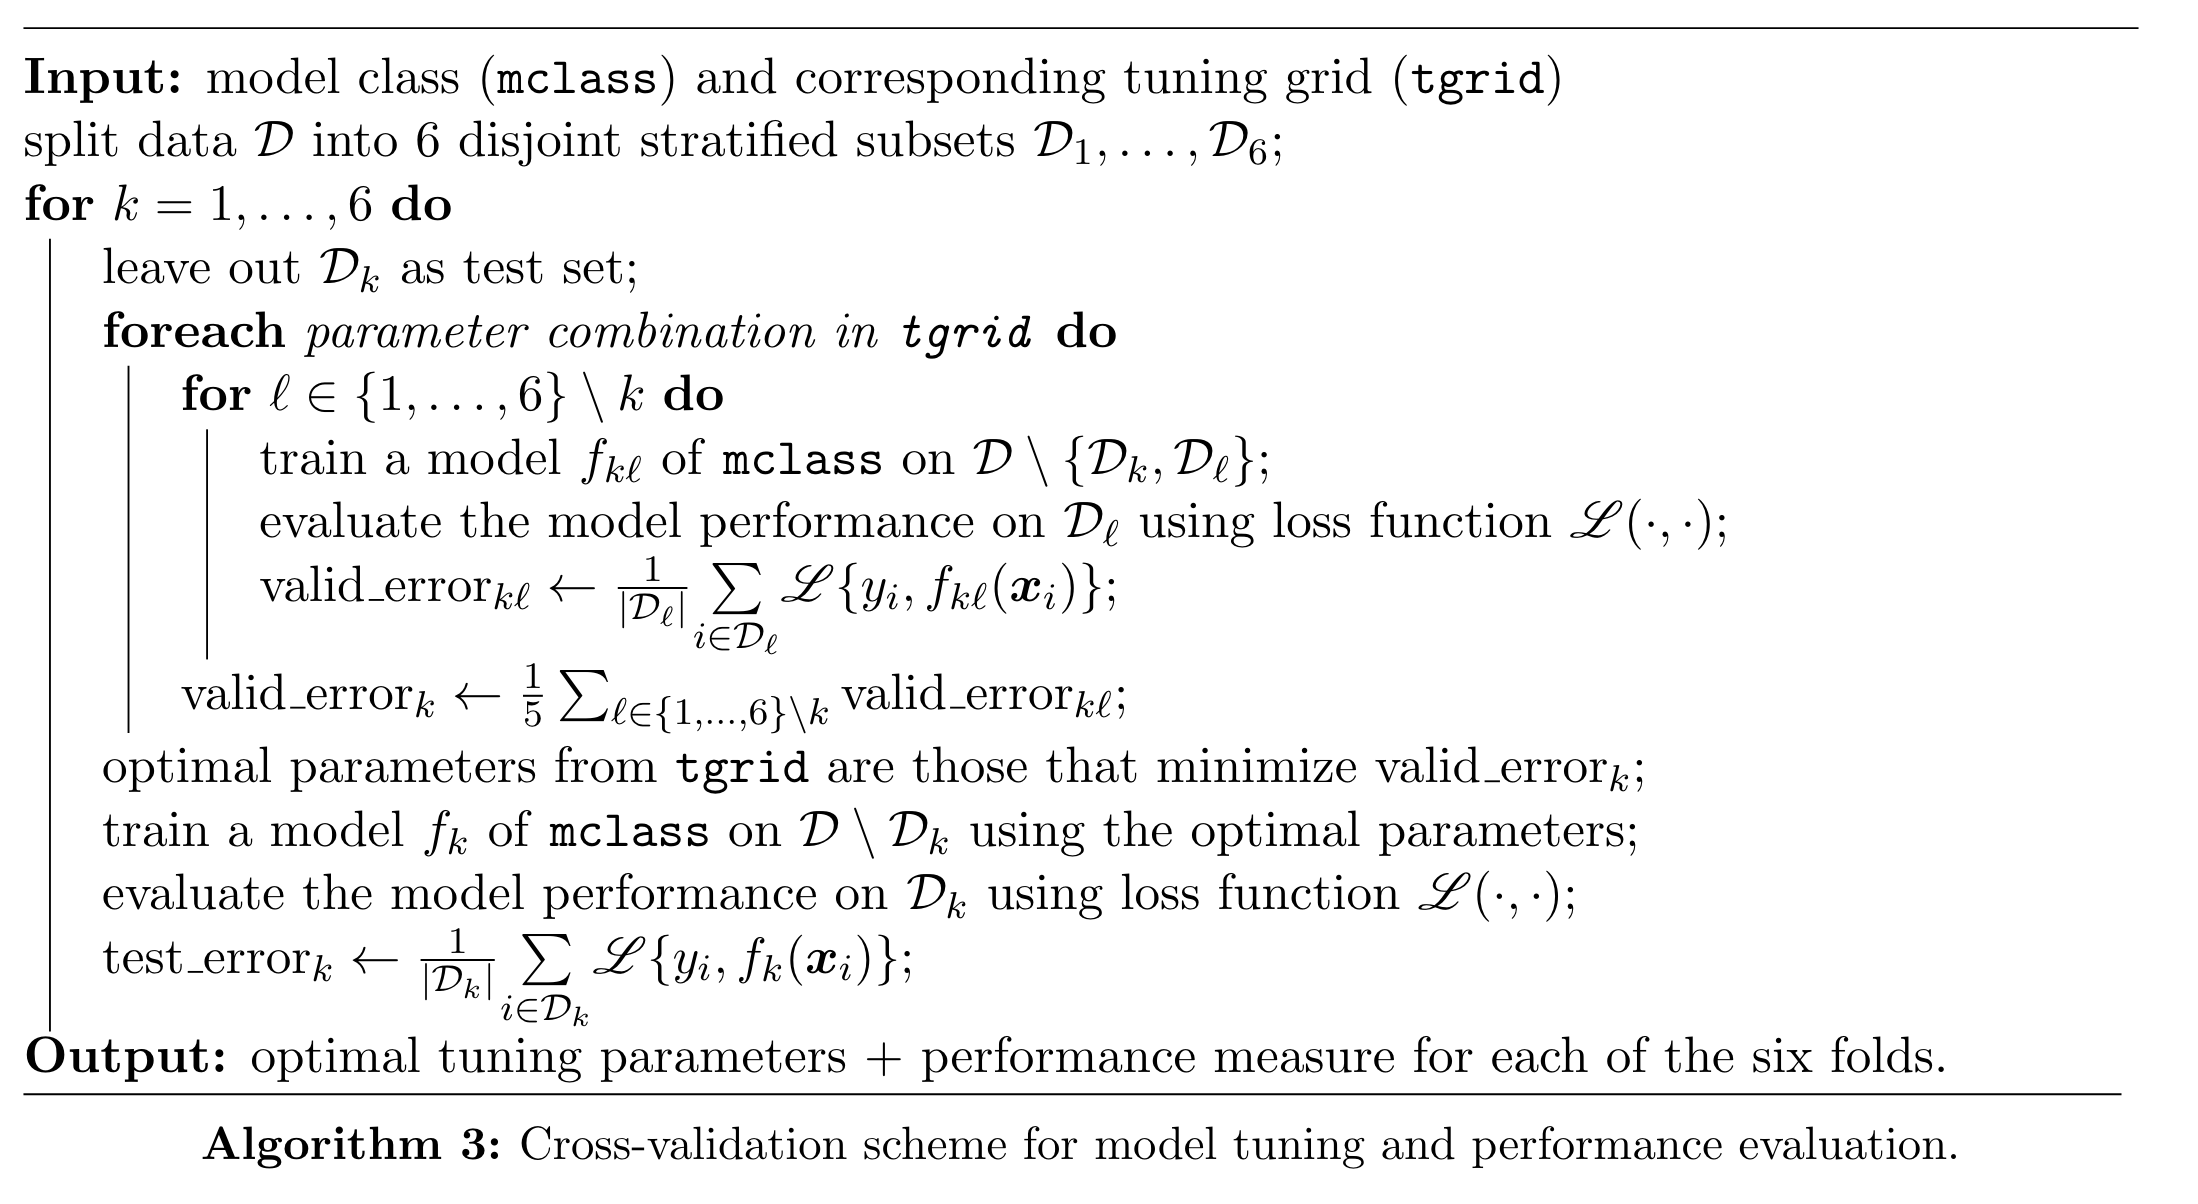

It involves partitioning the dataset into k equal-sized subsets, where the model is trained on k-1 folds and validated on the remaining fold iteratively. By repeating this process k times, with each fold serving as the validation set exactly once, cross-validation provides a robust estimate of a model's performance on unseen data. It helps in detecting overfitting, guides hyperparameter tuning, and aids in selecting the best model among alternatives. By aggregating the performance metrics across all folds, cross-validation offers a reliable assessment of a model's generalization ability, enhancing its reliability and applicability in real-world scenarios.

/var/folders/n3/j9s0z6s92fd1_xkmg3xk0twh0000gn/T/ipykernel_52719/145207184.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=models.keys())


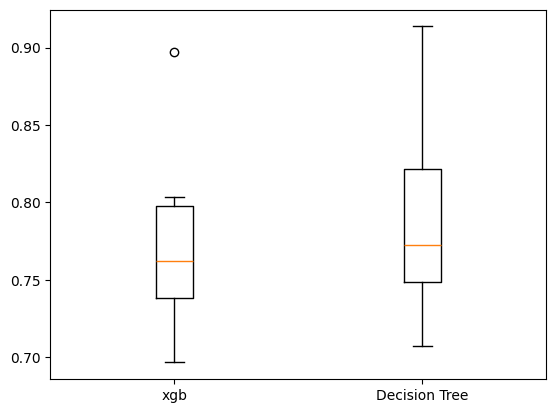

In [23]:
def poisson_deviance_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_poisson_deviance(y, y_pred)

models = {"xgb": gbm_freq, 
      "Decision Tree": tree_freq}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_freq, y_train_freq, cv=kf, scoring=poisson_deviance_scorer)
    results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.show()


Overall we can see that the xgboost performs better and more stable than decision tree. 

#### Comparing performance using unscaled data

In [28]:
poisson_dev1 = mean_poisson_deviance(y_test_freq, y_pred_freq_xg)
print("On Test data XGBoost poisson_deviance:", poisson_dev1)
poisson_dev1 = mean_poisson_deviance(y_test_freq, test_Tree_predictions)
print("On Test data tree poisson_deviance:", poisson_dev1)

On Test data XGBoost poisson_deviance: 0.7090702768140108
On Test data tree poisson_deviance: 0.7260394048677671


## Tuning and hyper-parameters Gridsearch CV

We can see it didn't improve when it comes to poisson deviance so we continue with our hyper parameters

# Severity modeling

We first subset the data keeping only the observations with actual claims
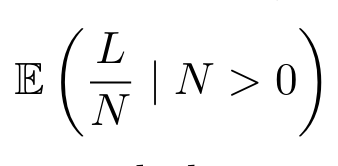

In [25]:

# subset the data based on claim amount
mtpl1_sev = mtpl1.query('nbrtotc >= 1 ')
mtpl1_sev.shape

###########################

X_sev = mtpl1_sev.drop(columns=['chargtot','duree', 'nbrtotan']) # 
#y = mtpl1_sev['nbrtotc']

# claim frequency (nclaims/expo) as target

y_mtpl_sev = np.array(mtpl1_sev.chargtot/mtpl1_sev.nbrtotc)
y_mtpl_sev_log = np.log(y_mtpl_sev)
# exposure as weights
w_mtpl_sev = np.array(mtpl1_sev.duree)
# cols to retain as features
sev_cols = X_sev.columns
# subset the data
X_mtpl_sev = X_sev[feat_cols]



# number of claims as weights

w_mtpl_sev = np.array(mtpl_sev.nbrtotc)


## to avoid deviding by 0
mask = mtpl1.nbrtotc != 0

# Perform division only where the mask is True, else assign zero
y_mtpl_sev1 = np.where(mask, mtpl1.chargtot / mtpl1.nbrtotc, 0)


# print the shape

print(X_sev.shape)


(18345, 16)


### Train and test split

In [26]:
# Split data into training and testing sets

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X_sev, y_mtpl_sev, test_size=0.2, random_state=42)


In [27]:
w_mtpl_sev = X_train_sev ['nbrtotc']
X_train_sev = X_train_sev.drop(columns=['nbrtotc'], inplace=False)
X_test_sev  = X_test_sev.drop(columns=['nbrtotc'], inplace=False)

# Decision tree SEVERITY

We couldn't adapt gamma in Decision tree, so this is our second best option Fit a MSE regression tree of depth one to the log-transformed target

Unfortunately, there is not an ideal way to model claim severities with a decision tree in scikit-learn because the distributional loss functions are not implemented

In [29]:
y_train_sev_log = np.log(y_train_sev)
y_train_sev_log

array([4.19809495, 4.2538661 , 6.66972327, ..., 5.04587155, 6.91616309,
       5.37511561])

In [30]:
tree_sev = DecisionTreeRegressor(criterion='squared_error', max_depth=10, min_samples_split=10000, min_samples_leaf=5000)
tree_sev.fit(X_train_sev, y_train_sev_log, w_mtpl_sev) # we apply sample_weight=w_mtpl_sev because we want value the data with higher duree


tree_sev

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5000,
                      min_samples_split=10000)

We decided to use weights because a higher durre provides better and more reliable insights. By incorporating weights, the model will apply a stricter loss function to instances with higher weights, thereby emphasizing their importance.

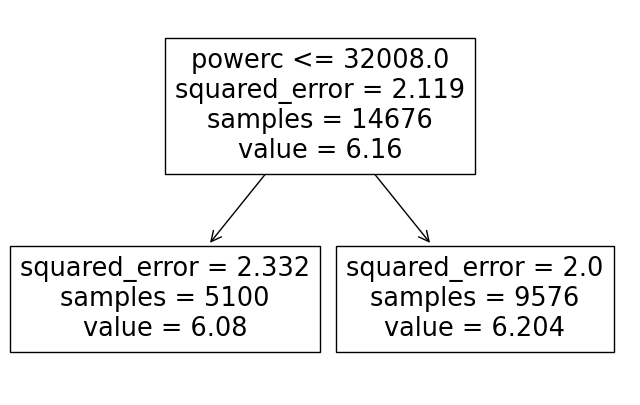

In [91]:
# plot the tree structure
plt.figure(figsize=(8, 5), dpi=100)
plot_tree(tree_sev, feature_names=sev_cols);

##### We can observe that the root node indeed predicts the weighted claim severity on the log scale for the entire portfolio:

In [32]:
# weighted mean of the protfolio log severity

np.sum(w_mtpl_sev * y_train_sev_log) / np.sum(w_mtpl_sev)

6.160473108015003

When we exponentiate the prediction result of the root node, we notice we are closer to the empirical median as to the mean severity:

In [33]:
b = np.sum(w_mtpl_sev * y_train_sev_log) / np.sum(w_mtpl_sev)
# exponent of the root node prediction
print(np.exp(b))
# overall mean
print(np.mean(mtpl_sev.chargtot))
# overall median
print(np.median(mtpl_sev.chargtot))

473.6521104439087
1794.030076789152
574.51803301


This can be explained in two different ways:
1. The mean of the log-normal distribution is equal to $\exp(\mu + \sigma^2/2)$ and we are calculating $\exp(\mu)$, which is the median. But unlike GLMs, we do not get a proper estimate for $\sigma$ in a decision tree, only an estimate for $\mu$.
2. The exponential of an average is not equal to the average of an exponential: $\exp(1/n\sum_1^n x_i) \neq 1/n \sum_i^n\exp(x_i)$, and by exponentiating after the root node prediction we are doing the first, while we should be doing the latter.

##### Evaluation on train data

In [38]:

train_predictions = np.exp(tree_sev.predict(X_train_sev))

# Calculate poisson_deviance on the training set
#exposure = mtpl1['duree']
gamma_deviance = mean_gamma_deviance(y_train_sev, train_predictions)
print("Training poisson_deviance:", gamma_deviance)


Training poisson_deviance: 4.895500200181983


##### Evaluation on test data

In [40]:
test_predictions = np.exp(tree_sev.predict(X_test_sev))
print(len(test_predictions))
gamma_deviance = mean_gamma_deviance(y_test_sev, test_predictions)
print("Training poisson_deviance:", gamma_deviance)

3669
Training poisson_deviance: 5.09223148691833


# Gradient boosting machine SEVERITY

In [41]:
params = {
    'objective': 'reg:gamma',  # gamma regression objective
    'max_depth': 6,  # Maximum depth of a tree
    'gamma': 0.1,  # Complexity penalty
    'subsample': 0.75,  # Percentage of data used to train each tree
    'learning_rate': 0.01,  # Shrinkage parameter
    'min_split_loss': 0.01,  # Enforces a stopping criterion for trees
    'eval_metric': 'gamma-deviance' , 
    'n_estimators':1000 #represents M in our Algo 10.3
}

# Define the XGBoost regressor with the specified parameters
gbm_sev = xgb.XGBRegressor(**params)

# Fit the model on the training data
gbm_sev.fit(X_train_sev, y_train_sev, sample_weight=w_mtpl_sev)

# Make predictions on the testing data
y_pred_sev_xg = gbm_sev.predict(X_test_sev)


#on all Data prediction

y_pred_sev_final = gbm_sev.predict(X) ## on all data

# Evaluate the model
mse = mean_gamma_deviance(y_test_sev, y_pred_sev_xg)
print("mean_gamma_deviance:", mse)

mean_gamma_deviance: 2.8823458444961876


We decided to use weights because a higher number of claims provides better and more reliable insights. By incorporating weights, the model will apply a stricter loss function to instances with higher weights, thereby emphasizing their importance.

### Tuning with random search<a name="#four-two-tuning"></a>


A grid search has the advantage that all possible combinations of tuning parameters are considered and the optimal combination is found. This procedure however becomes extremely time-consuming if a lot of tuning parameters are involved. In such a situation, a randomized search is better to save computation time. A randomized search simply tries *m* possible combinations out of *n* cases and returns the best performing one from this subset.

We start by defining our possible parameter values and initialize an `XGBRegressor` for claim severity:

In [60]:
gbm_sev

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='gamma-deviance',
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, min_split_loss=0.01,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None, ...)

In [79]:
# define dictionary for search
from sklearn.metrics import make_scorer

def gamma_deviance(y_true, y_pred):
    eps = np.finfo(float).eps  # small constant to avoid division by zero
    y_pred = np.maximum(y_pred, eps)
    y_true = np.maximum(y_true, eps)
    return np.abs(mean_gamma_deviance(y_true, y_pred))

gamma_scorer = make_scorer(gamma_deviance, greater_is_better=False)

param_dict = {'max_depth' : [1, 3, 5, 7, 9],
              'n_estimators' : [100, 200, 300],
              'colsample_bynode' : [0.5, 0.75, 1],
              'lambda' : [0, 0.1, 1],
              'alpha' : [0, 0.1, 1]}
# perform cross_validation
xgb_randomsearch = RandomizedSearchCV(estimator=gbm_sev,
                                      param_distributions=param_dict,
                                      scoring= gamma_scorer,
                                      n_iter=100,
                                      verbose=1,
                                      cv=6,
                                      random_state = 82)
xgb_randomsearch.fit(X_train_sev, y_train_sev, sample_weight=w_mtpl_sev)

# Get the best parameters and best score
best_params = xgb_randomsearch.best_params_
best_score = xgb_randomsearch.best_score_  

print("Best Parameters:", best_params)
print("Best gamma Deviance Score:", best_score)


Fitting 6 folds for each of 100 candidates, totalling 600 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 1, 'lambda': 1, 'colsample_bynode': 0.75, 'alpha': 1}
Best gamma Deviance Score: -55.021967047131945


In [80]:
pd.DataFrame(xgb_randomsearch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_lambda,param_colsample_bynode,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
26,0.130500,0.004679,0.002603,0.000250,300,1,1,0.75,1,"{'n_estimators': 300, 'max_depth': 1, 'lambda'...",-44.800129,-47.384508,-53.792289,-76.369878,-53.879688,-53.905310,-55.021967,10.186706,1
93,0.130461,0.005006,0.002835,0.000329,300,1,1,0.5,0.1,"{'n_estimators': 300, 'max_depth': 1, 'lambda'...",-44.801578,-47.377693,-53.786856,-76.378436,-53.878843,-53.908706,-55.022019,10.190368,2
16,0.136032,0.008754,0.002954,0.000285,300,1,0.1,0.5,0.1,"{'n_estimators': 300, 'max_depth': 1, 'lambda'...",-44.803315,-47.379334,-53.788950,-76.394445,-53.881350,-53.910267,-55.026277,10.195347,3
35,0.131490,0.005925,0.002700,0.000318,300,1,0.1,0.75,1,"{'n_estimators': 300, 'max_depth': 1, 'lambda'...",-44.803879,-47.388167,-53.795670,-76.378755,-53.886331,-53.911592,-55.027399,10.188415,4
57,0.127703,0.003814,0.003337,0.001077,300,1,1,1,0,"{'n_estimators': 300, 'max_depth': 1, 'lambda'...",-44.810889,-47.400393,-53.808550,-76.402429,-53.906552,-53.923512,-55.042054,10.193130,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,0.099980,0.007630,0.003808,0.000930,100,7,0,1,0.1,"{'n_estimators': 100, 'max_depth': 7, 'lambda'...",-356.657188,-375.342854,-420.618446,-581.909850,-421.785563,-421.885112,-429.699835,72.645229,96
7,0.097161,0.005362,0.003655,0.000518,100,5,0.1,0.75,0,"{'n_estimators': 100, 'max_depth': 5, 'lambda'...",-356.662135,-375.348021,-420.624217,-581.913544,-421.818938,-421.894996,-429.710309,72.644143,97
68,0.097614,0.003570,0.003995,0.000978,100,5,0,0.5,0,"{'n_estimators': 100, 'max_depth': 5, 'lambda'...",-356.672191,-375.346767,-420.664137,-581.975761,-421.820958,-421.926406,-429.734370,72.662909,98
28,0.107222,0.007211,0.003503,0.000237,100,5,0,1,0,"{'n_estimators': 100, 'max_depth': 5, 'lambda'...",-356.691953,-375.375313,-420.688719,-582.024859,-421.861580,-421.952064,-429.765748,72.671473,99


## Tariffs using Xgboost results 
Now all ML models are fit, we can start analyzing them. To streamline this process, we define a predict function `predict_model` that can be applied to the different models in a uniform way:


In [81]:
Losses = y_pred_sev_final * y_pred_freq_final
Losses_df = pd.DataFrame({'Losses': Losses})

# Concatenate X and price_df along the columns axis (axis=1)
Tarif = pd.concat([X, Losses_df], axis=1)
Tarif

,ageph,codposs,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long,Losses
0,64,1000,1,0,1,1,0,0,0,1,0,21004,85,50.833333,4.350000,124.883209
1,28,1000,2,0,1,2,0,0,0,0,0,21004,85,50.833333,4.350000,2691.542480
2,58,1000,3,0,1,3,0,0,0,0,1,21004,85,50.833333,4.350000,239.004501
3,62,1000,3,0,1,1,0,0,0,1,1,21004,85,50.833333,4.350000,117.105934
4,41,1000,2,0,1,12,0,0,0,0,0,21004,85,50.833333,4.350000,381.159485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,2,1,1,1,0,0,0,0,1,24041,232,50.766667,4.883333,154.183167
163653,42,4770,3,1,0,1,0,0,0,0,1,63001,9,50.350000,6.166667,155.690994
163654,48,4770,3,1,1,12,0,0,0,0,1,63001,9,50.350000,6.166667,41.082958
163655,27,4770,2,1,1,2,0,0,0,0,1,63001,9,50.350000,6.166667,257.396088


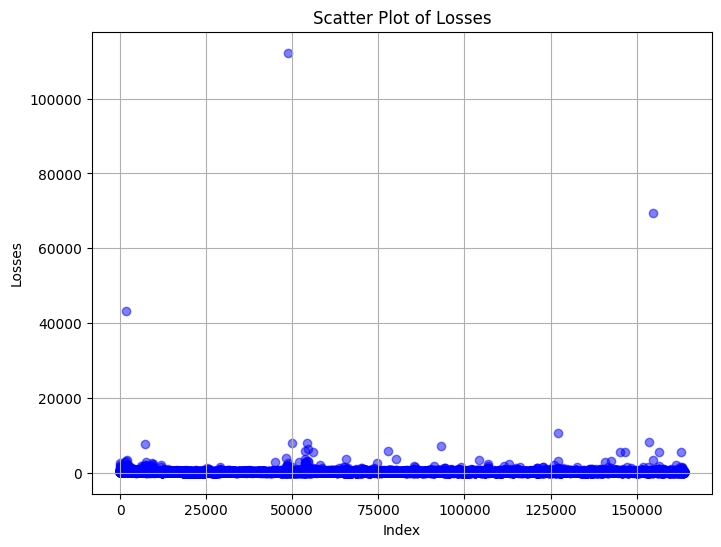

In [82]:
# Assuming 'concatenated_df' is your DataFrame and 'column_name' is the name of the column you want to plot
column_name = 'Losses'

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Tarif.index, Tarif[column_name], c='blue', marker='o', alpha=0.5)
plt.xlabel('Index')  # Assuming you want the index on the x-axis
plt.ylabel(column_name)  # Name of the column on the y-axis
plt.title(f'Scatter Plot of {column_name}')
plt.grid(True)
plt.show()

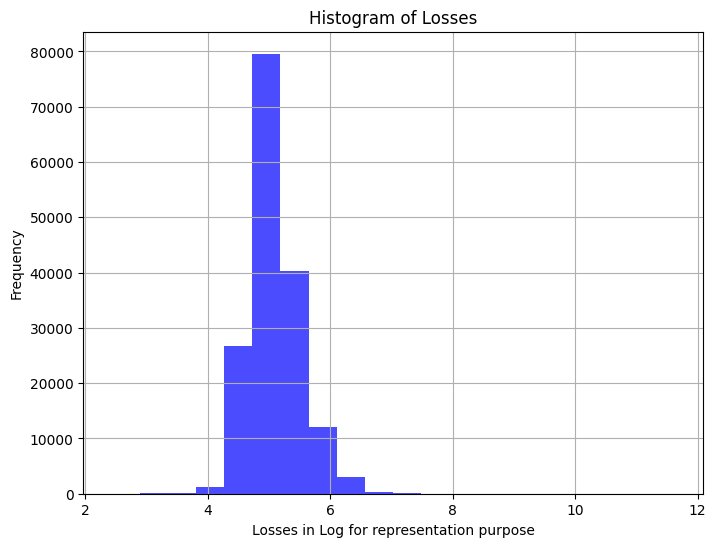

In [83]:
# Histogram
plt.figure(figsize=(8, 6))
plt.hist(np.log(Tarif[column_name]), bins=20, color='blue', alpha=0.7)
plt.xlabel('Losses in Log for representation purpose')
plt.ylabel('Frequency')
plt.title(f'Histogram of {column_name}')
plt.grid(True)
plt.show()


#### In Loss model course we have seen and proved that a Poisson–Gamma Mixture Is Negative-Binomially Distributed

This is why we decided to fit the very disperse premiums assuming a neg binomial distribution.


In [84]:
import statsmodels.api as sm

y_price=Tarif['Losses']

# Fit a negative binomial regression model
model = sm.GLM(y_price, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Losses   No. Observations:               163657
Model:                            GLM   Df Residuals:                   163642
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0081e+06
Date:                Mon, 20 May 2024   Deviance:                       23103.
Time:                        21:37:15   Pearson chi2:                 3.92e+05
No. Iterations:                    10   Pseudo R-squ. (CS):            0.07267
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ageph         -0.0153      0.000    -88.448      0.0

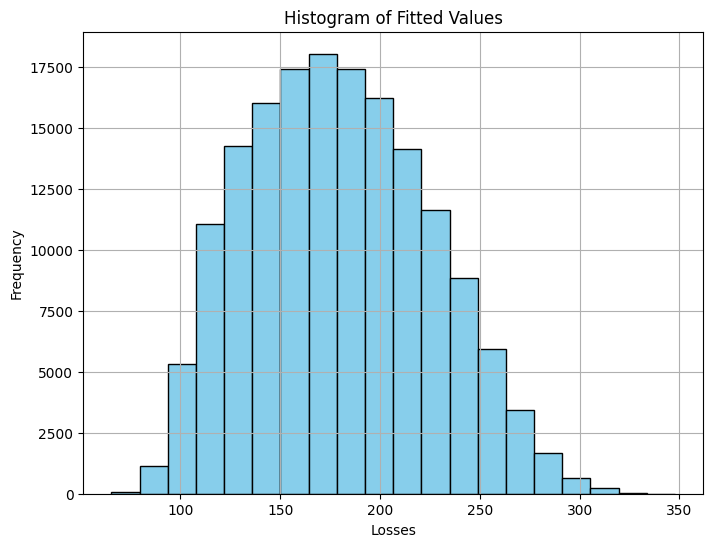

In [85]:
# Get the fitted values
fitted_values = result.fittedvalues

# Plot a histogram of the fitted values
plt.figure(figsize=(8, 6))
plt.hist(fitted_values, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.title('Histogram of Fitted Values')
plt.grid(True)
plt.show()

#### Loading for expenses and profit 

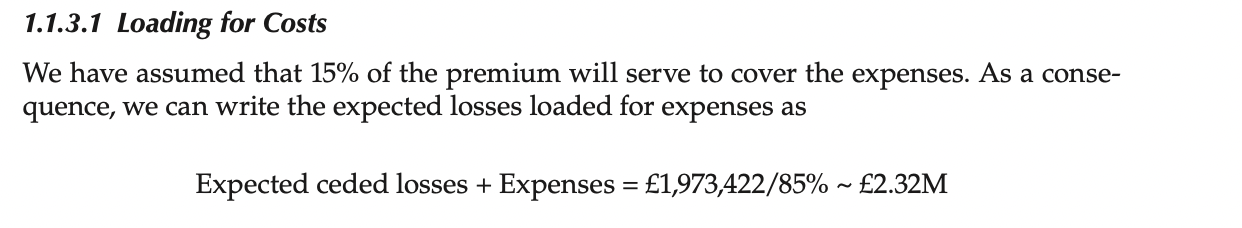

In [86]:
pred_loss = result.predict(X)
pred_loss = pred_loss*mtpl_orig['duree']
pred_Price_df = pd.DataFrame({'Expected ceded losses': pred_loss})
# Concatenate X and price_df along the columns axis (axis=1)
Expenses = 0.85
Profit = 0.9
return_on_invest = 0.03
Technical_premium = ((pred_loss/Expenses)/ (return_on_invest+1))/Profit
Technical_premium = pd.DataFrame({'Technical premium XGboost': Technical_premium})
Tarif2 = pd.concat([mtpl_orig, pred_Price_df,Technical_premium], axis=1)
Tarif2


,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,Expected ceded losses,Technical premium XGboost
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,138.044868,175.194959
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,12.621952,16.018722
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,70.184643,89.072458
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110,25.594238,32.482059
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66,240.611708,305.364184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,50,9960,1.000000,0.000000,0,0.000000,0.000000,2-5,Male,Petrol,Once,Private,No,No,MTPL+,<66,109.493628,138.960122
163653,86,9960,1.000000,0.000000,0,0.000000,0.000000,6-10,Male,Petrol,Once,Private,No,No,MTPL,<66,176.119587,223.516197
163654,64,9960,1.000000,0.000000,0,0.000000,0.000000,2-5,Male,Petrol,Twice,Private,No,No,MTPL,<66,165.485256,210.019996
163655,58,9970,1.000000,0.000000,1,1.000000,3177.994988,>10,Male,Petrol,Once,Private,Yes,No,MTPL,<66,200.993995,255.084707


## Model interpretation

### Variable importance

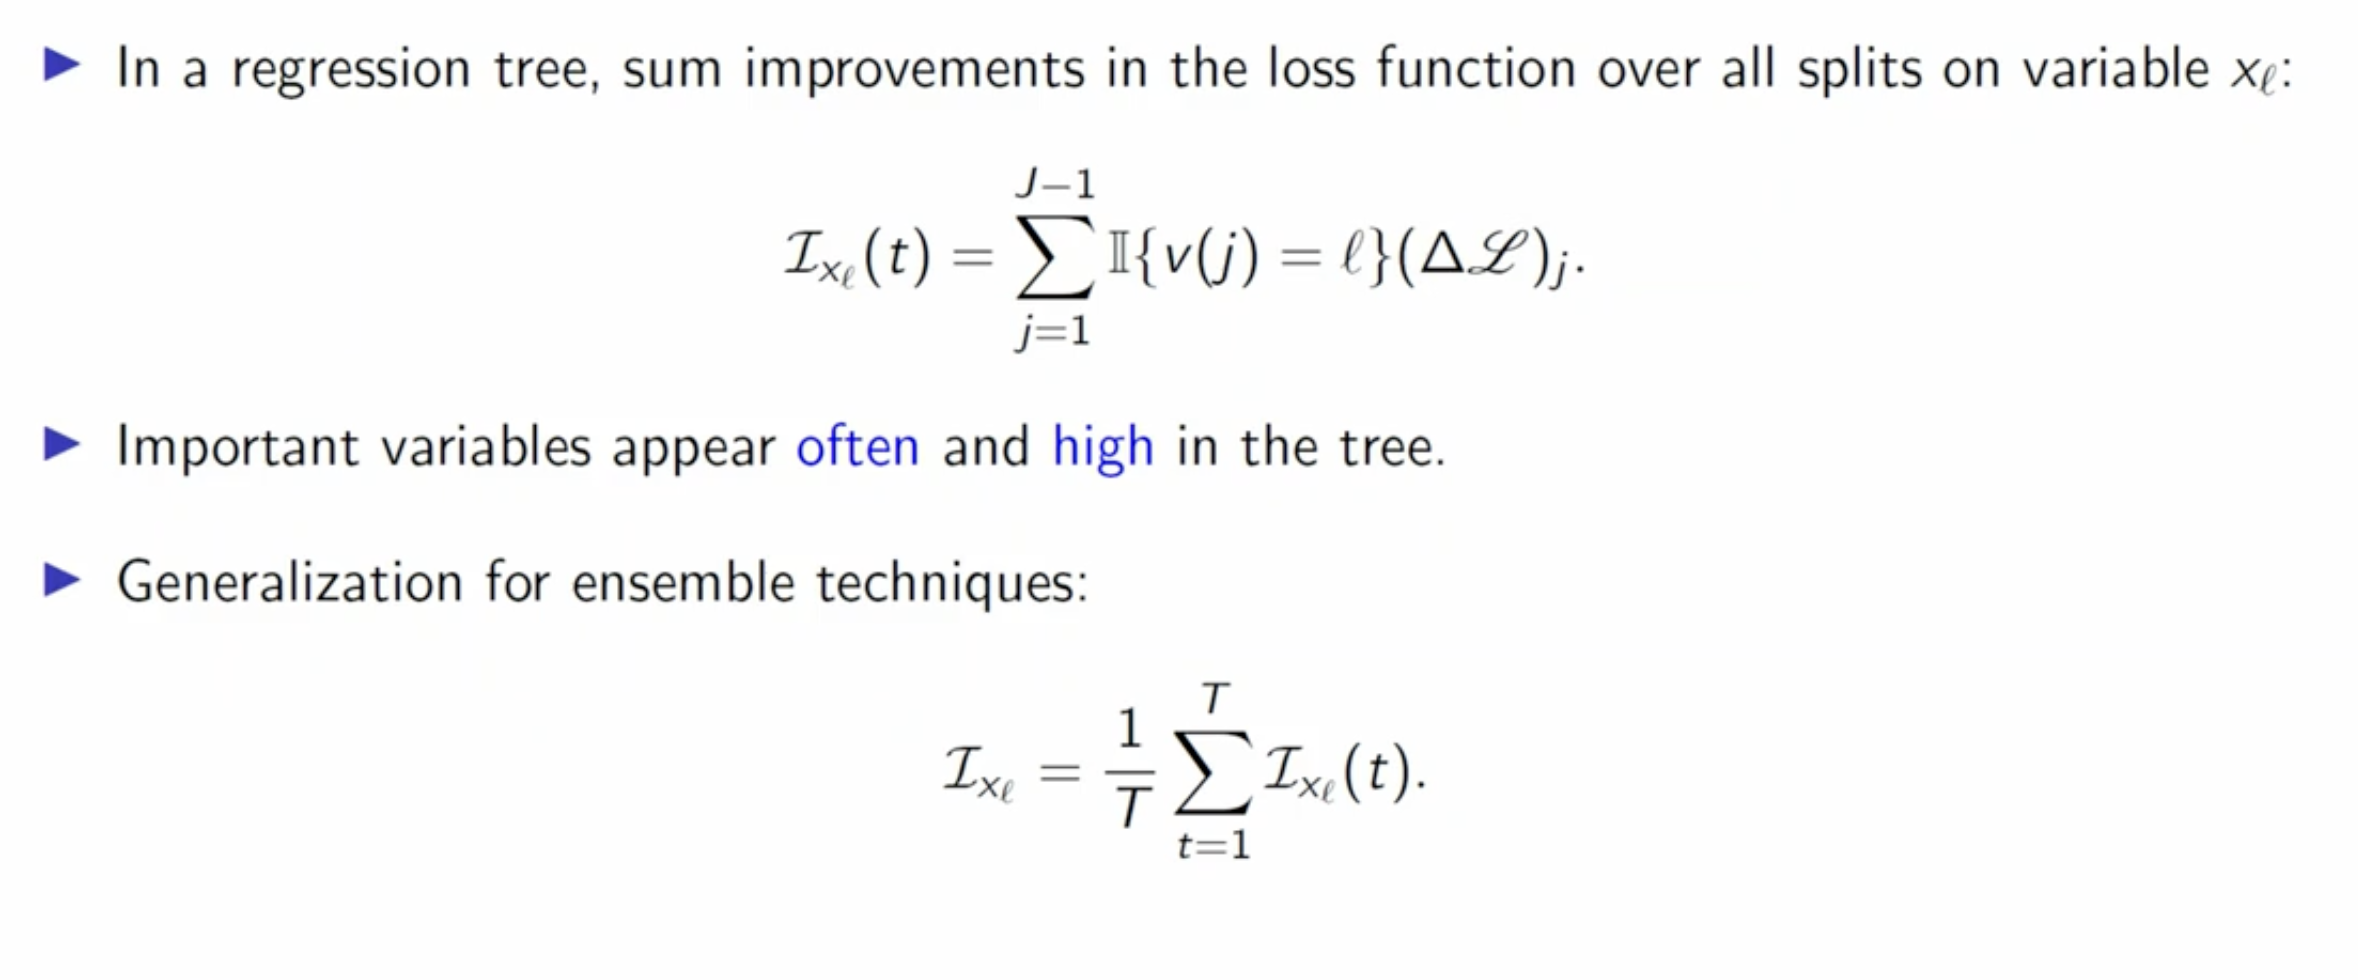

Here we have the theorical explenation on how it choses the important features. In a decision tree, the importance of a feature is evaluated based on how much it improves the performance of the model at each split.
XGBoost and other ensemble methods (like Random Forests): These models consist of multiple trees. Feature importance in these models is calculated by averaging the importance of each feature across all the trees in the ensemble.


To estimate feature importance in a single tree, we can look at the structure of the tree. Features that appear closer to the top (root) are generally more important as they split the data earlier, influencing a larger portion of the data.

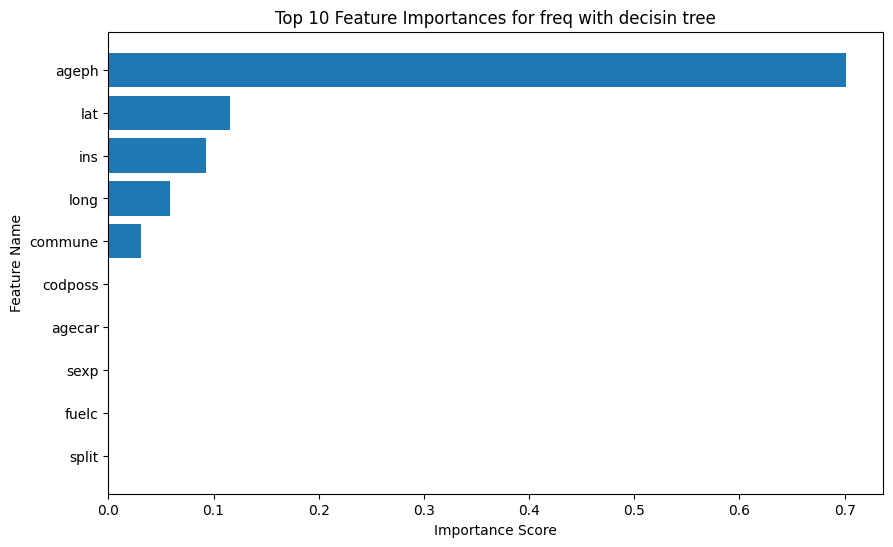

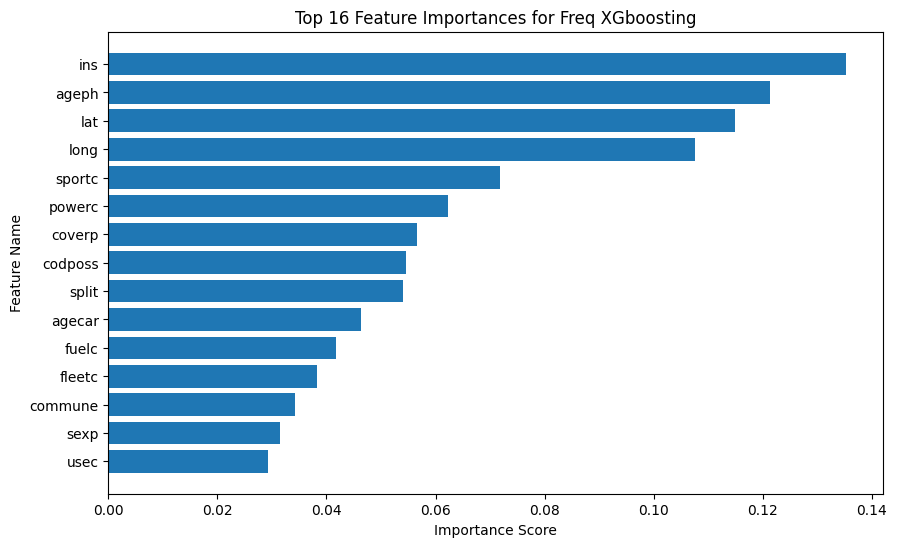

In [87]:
tree_freq_fi = pd.DataFrame({'feature': tree_freq.feature_names_in_, 'importance': tree_freq.feature_importances_})
tree_freq_fi = tree_freq_fi.sort_values('importance', ascending=False)

# Plot feature importance as box plots for the top N features
top_n = 10  # Specify the number of top features to plot
top_n_features = tree_freq_fi['feature'].head(top_n)
top_n_importances = tree_freq_fi['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for freq with decisin tree')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()



tree_freq_fi = pd.DataFrame({'feature': gbm_freq.feature_names_in_, 'importance': gbm_freq.feature_importances_})
tree_freq_fi = tree_freq_fi.sort_values('importance', ascending=False)

# Plot feature importance as box plots for the top N features
top_n = 16  # Specify the number of top features to plot
top_n_features = tree_freq_fi['feature'].head(top_n)
top_n_importances = tree_freq_fi['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for Freq XGboosting')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()



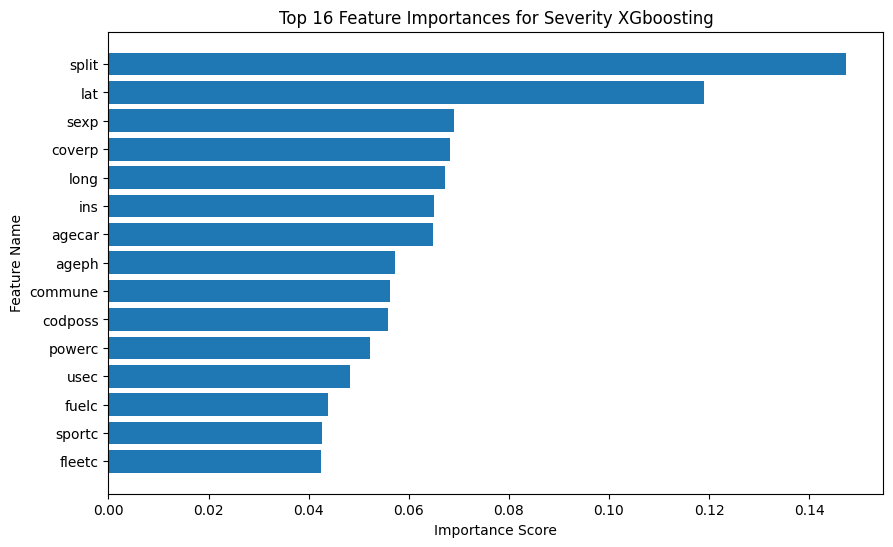

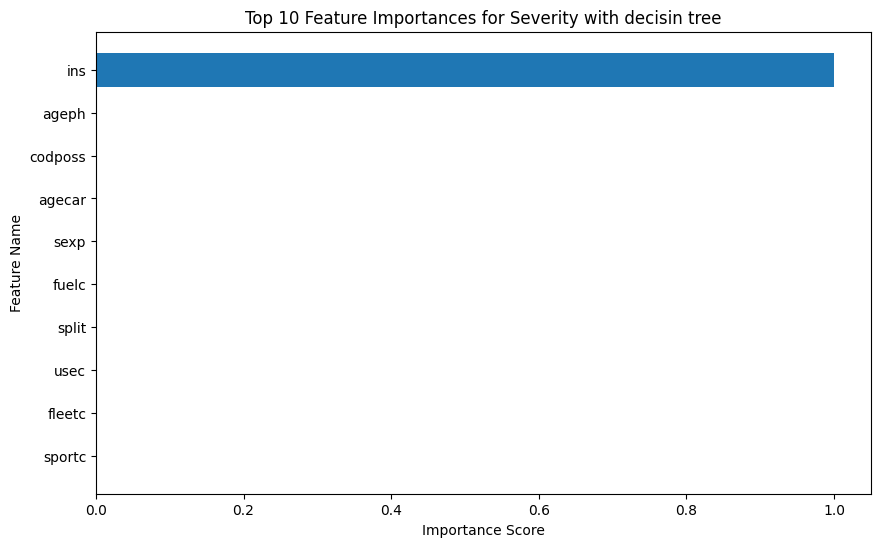

In [88]:
tree_freq_fi = pd.DataFrame({'feature': gbm_sev.feature_names_in_, 'importance': gbm_sev.feature_importances_})
tree_freq_fi = tree_freq_fi.sort_values('importance', ascending=False)

# Plot feature importance as box plots for the top N features
top_n = 16 # Specify the number of top features to plot
top_n_features = tree_freq_fi['feature'].head(top_n)
top_n_importances = tree_freq_fi['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for Severity XGboosting')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()

tree_freq_fi = pd.DataFrame({'feature': tree_sev.feature_names_in_, 'importance': tree_sev.feature_importances_})
tree_freq_fi = tree_freq_fi.sort_values('importance', ascending=False)

# Plot feature importance as box plots for the top N features
top_n = 10  # Specify the number of top features to plot
top_n_features = tree_freq_fi['feature'].head(top_n)
top_n_importances = tree_freq_fi['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for Severity with decisin tree')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()



### Partial dependence plots (PDPs)

It helps in uncovering the localized behavior of features and their impact on predictions.

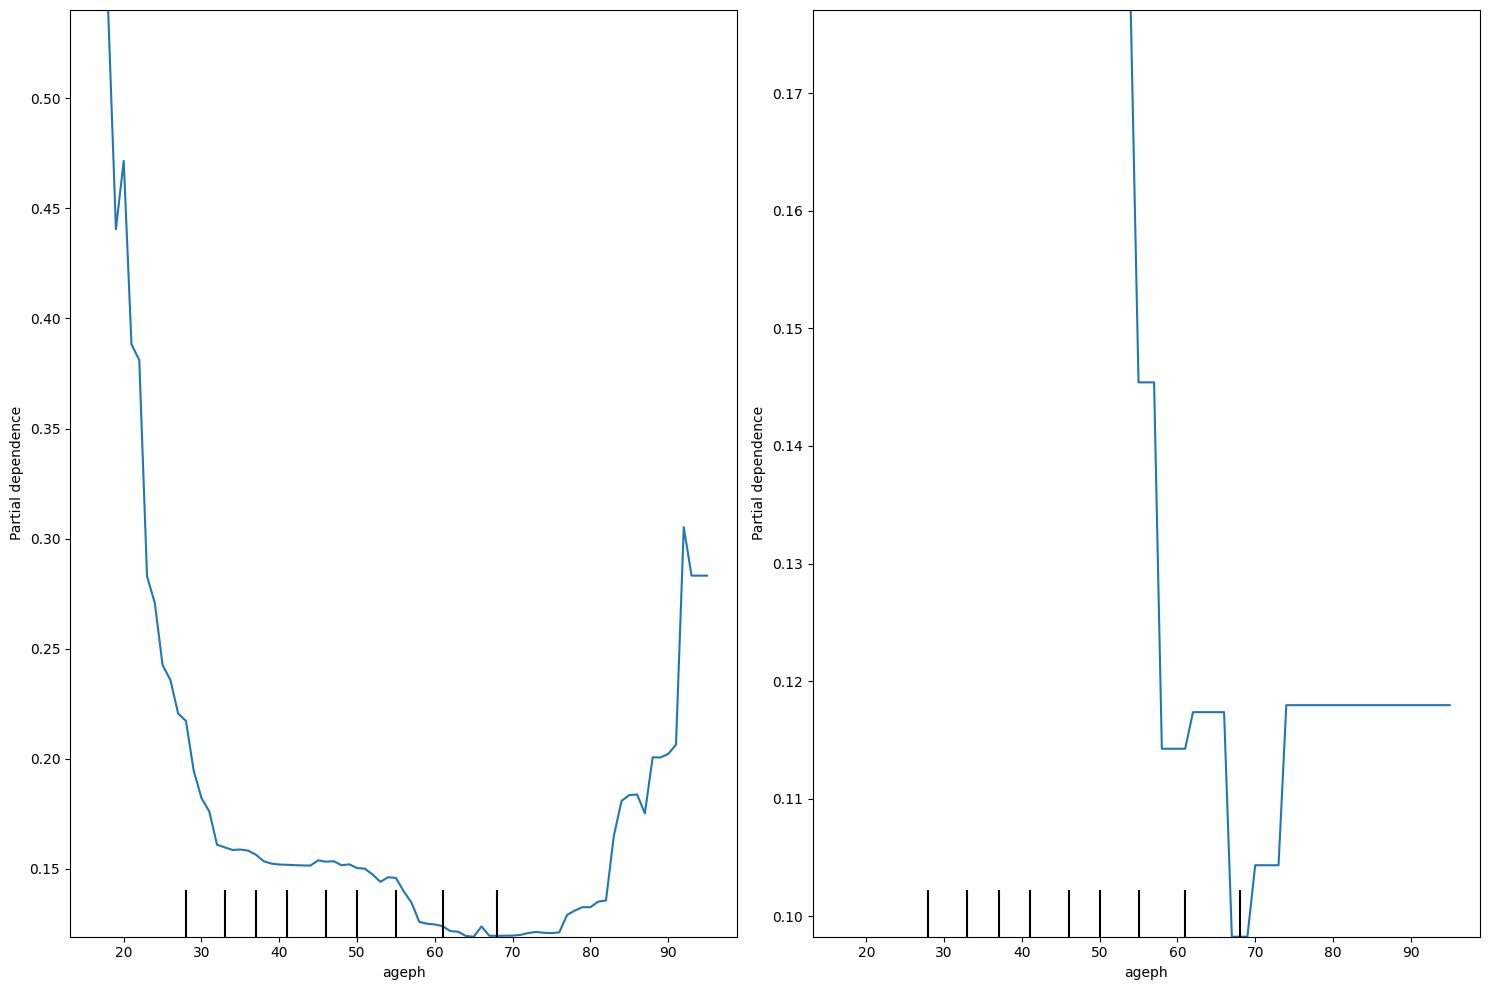

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
PartialDependenceDisplay.from_estimator(gbm_freq, X_mtpl_freq, features = ['ageph'],  kind='average', ax=axs[0])

PartialDependenceDisplay.from_estimator(tree_freq, X_mtpl_freq, features = ['ageph'],  kind='average', ax=axs[1])

plt.tight_layout()
plt.show()

The likelihood of filing a claim is elevated among younger policyholders and gradually diminishes as age increases, reaching a plateau around age 35. Subsequently, the risk begins to decline again around age 50 but increases for senior policyholders around age 70. The age effect depicted in the Right panel of this graph reflects the insights from XGboost and on Left from decision Tree.

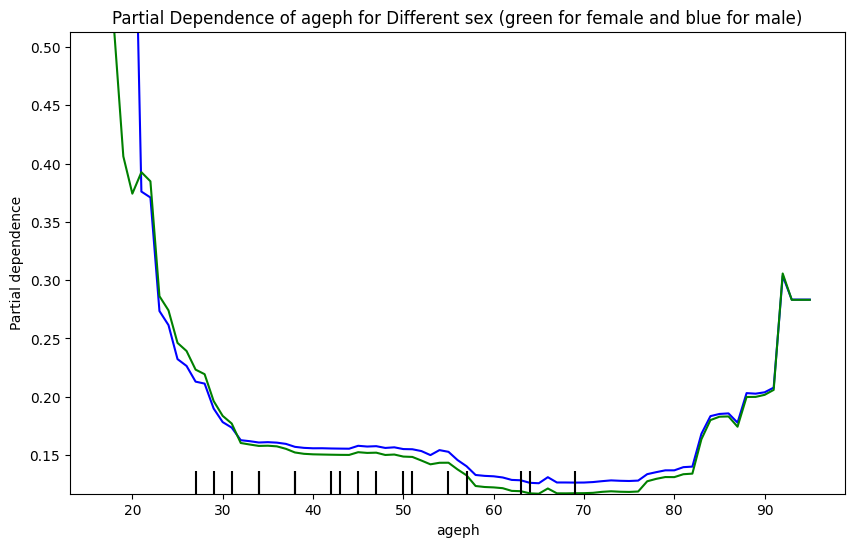

In [90]:
# Define your subsets
subset1 = X_mtpl_freq[X_mtpl_freq['sexp'] == 0]
subset2 = X_mtpl_freq[X_mtpl_freq['sexp'] == 1]

fig, ax = plt.subplots(figsize=(10, 6))

# Generate partial dependence plots for the first subset
disp1 = PartialDependenceDisplay.from_estimator(gbm_freq, subset1, features=['ageph'], kind='average', ax=ax, line_kw={'color': 'blue'})

# Generate partial dependence plots for the second subset using display.axes_
disp2 = PartialDependenceDisplay.from_estimator(gbm_freq, subset2, features=['ageph'], kind='average', ax=disp1.axes_, line_kw={'color': 'green'})

# Manually add legend
handles = [plt.Line2D([0], [0], color='blue', lw=2, label='Low Income Level'),
           plt.Line2D([0], [0], color='green', lw=2, label='Medium Income Level')]

ax.legend(handles=handles)

# Setting title and labels
ax.set_title('Partial Dependence of ageph for Different sex (green for female and blue for male)')
ax.set_xlabel('ageph')
ax.set_ylabel('Partial Dependence')

# Display the plot
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:508: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


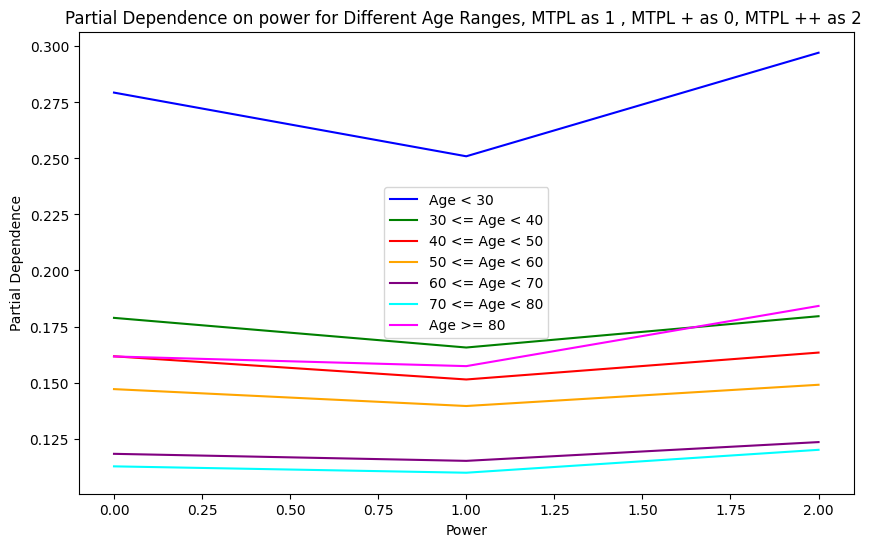

In [92]:
# Define subsets based on age ranges
subset1 = X_mtpl_freq[X_mtpl_freq['ageph'] < 30]
subset2 = X_mtpl_freq[(X_mtpl_freq['ageph'] >= 30) & (X_mtpl_freq['ageph'] < 40)]
subset3 = X_mtpl_freq[(X_mtpl_freq['ageph'] >= 40) & (X_mtpl_freq['ageph'] < 50)]
subset4 = X_mtpl_freq[(X_mtpl_freq['ageph'] >= 50) & (X_mtpl_freq['ageph'] < 60)]
subset5 = X_mtpl_freq[(X_mtpl_freq['ageph'] >= 60) & (X_mtpl_freq['ageph'] < 70)]
subset6 = X_mtpl_freq[(X_mtpl_freq['ageph'] >= 70) & (X_mtpl_freq['ageph'] < 80)]
subset7 = X_mtpl_freq[X_mtpl_freq['ageph'] >= 80]

# Store subsets and their corresponding labels and colors in lists
subsets = [subset1, subset2, subset3, subset4, subset5, subset6, subset7]
subset_labels = ['Age < 30', '30 <= Age < 40', '40 <= Age < 50', '50 <= Age < 60', '60 <= Age < 70', '70 <= Age < 80', 'Age >= 80']
subset_colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta']

# Plot partial dependence for each subset
fig, ax = plt.subplots(figsize=(10, 6))
for subset, label, color in zip(subsets, subset_labels, subset_colors):
    pdp, axes = partial_dependence(gbm_freq, subset, features=['powerc'], grid_resolution=50)
    ax.plot(axes[0], pdp[0], label=label, color=color)


# Customize labels and title
ax.set_xlabel('Power')
ax.set_ylabel('Partial Dependence')
ax.set_title('Partial Dependence on power for Different Age Ranges, MTPL as 1 , MTPL + as 0, MTPL ++ as 2 ')
ax.legend()

plt.show()



The graph illustrates how the likelihood of insurance claims changes with power for different age groups. Younger policyholders show higher claim probabilities at high power, gradually decreasing with age until around 35 years, followed by fluctuations and a rise again for seniors older 80. Comparing these trends between models helps assess their performance and interpretive differences, offering valuable insights for refining risk assessment strategies.

## Interaction effects


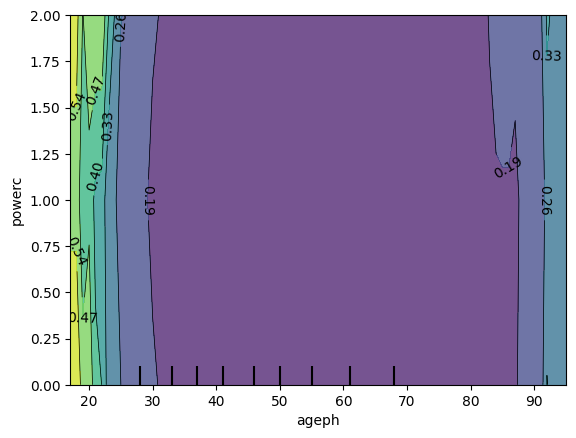

In [93]:
PartialDependenceDisplay.from_estimator(gbm_freq, X, features = [('ageph','powerc')], kind='average');

The graph visually demonstrates how power and age jointly influence predicted claim frequency, using color variations to represent different frequency levels. This insight is invaluable for accurate risk assessment and strategic decision-making in the insurance industry. Again, Younger policyholders show higher claim probabilities at high power, gradually decreasing with age until around 35 years, followed by fluctuations and a rise again for seniors older 80. 

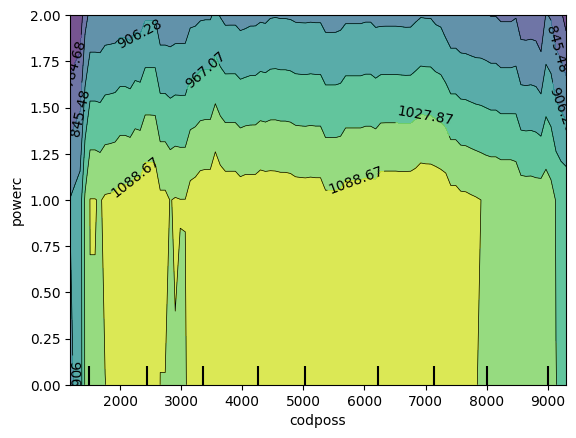

In [94]:
PartialDependenceDisplay.from_estimator(gbm_sev, X, features = [('codposs','powerc')], kind='average');

## Statistical performance
After gaining some insights from the different ML models, we now put focus on comparing the out-of-sample performance on the test data . We predict each ML model on the test data:


In [95]:
print('Poisson deviance in out of sample for frequency while using decision tree is  ' , mean_poisson_deviance(y_test_freq, tree_freq.predict(X_test_freq)))
print('Poisson deviance in out of sample for frequency while using XGboost is  ' , mean_poisson_deviance(y_test_freq, gbm_freq.predict(X_test_freq)))
print('Gamma deviance in out of sample for severity while using decision tree is  ' , mean_gamma_deviance(y_test_sev, np.exp(tree_sev.predict(X_test_sev))))
print('Gamma deviance in out of sample for severity while using XGboost is  ' , mean_gamma_deviance(y_test_sev, gbm_sev.predict(X_test_sev)))


Poisson deviance in out of sample for frequency while using decision tree is   0.7260394048677671
Poisson deviance in out of sample for frequency while using XGboost is   0.7090702768140108
Gamma deviance in out of sample for severity while using decision tree is   5.09223148691833
Gamma deviance in out of sample for severity while using XGboost is   2.8823458444961876


## Economic lift

After comparing the ML models for frequency and severity, we now turn to a comparison at the premium level. We calculate the predicted premiums for the test data  by multiplying the frequency and severity:



IT got really confusing since the unseen data are diffrent for sev and freq 


#### Premuim with DT on all data

In [124]:
Tree_Losses= (tree_freq.predict(X)/mtpl['duree']) * np.exp(tree_sev.predict(X))

### Technical prem
    
pred_Price_df = pd.DataFrame({'Expected ceded losses': Tree_Losses})
# Concatenate X and price_df along the columns axis (axis=1)
Expenses = 0.85
Profit = 0.9
return_on_invest = 0.03
Technical_premium1 = ((Tree_Losses/Expenses)/ (return_on_invest+1))/Profit
Technical_premium1 = pd.DataFrame({'Technical premium with Decision tree ': Technical_premium1})
Premuim_DT = pd.concat([mtpl_orig, pred_Price_df,Technical_premium1], axis=1)

print (np.mean(Tarif2),np.mean(Premuim_DT))


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


AGEPH                          47.000629
CODPOSS                      5270.912408
duree                           0.889786
lnexpo                         -0.212509
nbrtotc                         0.123979
nbrtotan                        0.157575
chargtot                      201.100361
Expected ceded losses         159.609490
Technical premium XGboost     202.562968
dtype: float64 AGEPH                                      47.000629
CODPOSS                                  5270.912408
duree                                       0.889786
lnexpo                                     -0.212509
nbrtotc                                     0.123979
nbrtotan                                    0.157575
chargtot                                  201.100361
Expected ceded losses                     174.051674
Technical premium with Decision tree      220.891775
dtype: float64


In [125]:
Tarif_final = pd.concat([Tarif2, Technical_premium1], axis=1)


In [127]:
# Plotting

df_50 = Tarif_final.iloc[:50]
df_51 = Tarif_final.iloc[:50]
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_50.index, y='TTechnical premium with Decision tree ', data=df_50, label='DT', marker='o')
sns.scatterplot(x=df_51.index, y='Technical premium XGboost', data=df_51, label='XG', marker='s')
# Adding titles and labels
plt.title('Scatter Plot of 50 premuims with decision tree and XG boost with Index as X-axis')
plt.xlabel('Index')
plt.ylabel('Technical premium')
plt.legend()

# Display the plot
plt.show()

ValueError: Could not interpret value `TTechnical premium with Decision tree ` for parameter `y`

<Figure size 1000x500 with 0 Axes>

### Loss ratio on all data 

In [139]:

print('Total expected loss with decision tree:  ' , np.sum(Tree_Losses))
print('Total expected loss with XGBoost:  ' ,np.sum(Tarif_final['Expected ceded losses']))



print(' Loss ratio for XGboost : ',np.sum(Tarif_final['Expected ceded losses'])/np.sum(Tarif_final['Technical premium XGboost']))
print(' Loss ratio for Decision tree : ', np.sum(Tree_Losses)/np.sum(Tarif_final['Technical premium with Decision tree ']))





Total expected loss with decision tree:   28484774.826139346
Total expected loss with XGBoost:   26121210.379536778
 Loss ratio for XGboost :  0.7879499999999999
 Loss ratio for Decision tree :  0.78795


A loss ratio below 100% indicates that the insurer is generating profits from its underwriting activities. In this case, the earned premiums exceed the incurred losses, resulting in a profitable operation. A low and stable loss ratio is desirable for insurers as it indicates profitability and effective risk management. Insurers strive to maintain a balance between competitive pricing and risk exposure to achieve sustainable underwriting results.









### Gini index

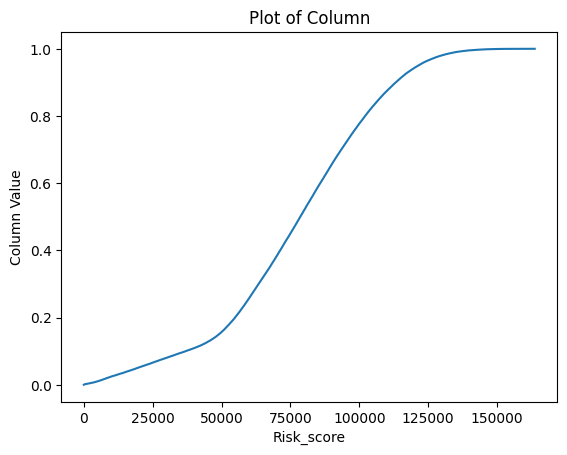

In [108]:
import scipy.stats as stats

def calculate_risk_score(data):
    ecdf = stats.cumfreq(data, numbins=len(data))
    ecdf_values = ecdf.cumcount / len(data)
    return ecdf_values

Risk_score_price = calculate_risk_score(Tarif2['Technical premium XGboost'])

#Sort Tarif2

sorted_Tarif2 = Tarif2.sort_values(by='Technical premium XGboost', ascending=True)


Risk_score_price = pd.DataFrame({'Risk_score_price': Risk_score_price})
# Concatenate X and price_df along the columns axis (axis=1)
sorted_Tarif2 = pd.concat([sorted_Tarif2.reset_index(drop=True), Risk_score_price.reset_index(drop=True)], axis=1)

plt.plot(Tarif2.index, sorted_Tarif2['Risk_score_price'])
plt.xlabel('Risk_score')
plt.ylabel('Column Value')
plt.title('Plot of Column')
plt.show()

In [168]:
def gini_index(loss_column, score_columns, data):
  

    gini_indices = {}

    for model in score_columns:
        # Calculate Gini index for each model
        gini_idx = gini(data[model] / data[loss_column])
        gini_indices[model] = gini_idx

    return gini_indices
